# ml-challenge-2023-30412
### Alessandro Morosini 3149086

# Loading

## Libaries

In [1]:
import os
import json
import numpy as np 
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F

from geopy import distance

pd.set_option('display.max_columns', 500)
cwd = Path(os.getcwd())

## Datasets

In [2]:
df = pd.read_csv(
    cwd / "data" / "train.csv",
    index_col="id",
    dtype={
        "price": float,
    },
)

In [3]:
test = pd.read_csv(
    cwd / "data" / "test.csv",
    index_col="id",
    dtype={
        "price": float,
    },
)

In [4]:
df_raw = df.copy()

# Exploratory Data Analyis

In [5]:
print(df.shape)
df.head()

(46312, 16)


,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
id,,,,,,,,,,,,,,,,
10461,60000.0,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0
51304,900000.0,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0
33032,33000.0,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0
62281,166000.0,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0
45681,410000.0,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0


In [6]:
df.describe()

,price,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
count,4.631200e+04,32366.000000,46299.000000,46299.000000,2.640900e+04,30158.000000,44281.000000,43896.000000,28869.000000,27963.000000,45959.000000,46299.000000,45869.000000
mean,5.031879e+05,1958.032874,43.534743,11.451295,5.091382e+03,195.285132,2.033333,1.559140,0.952510,5.724207,3.284166,0.994756,114.866620
std,1.106504e+06,72.021035,1.789416,1.502453,7.600521e+05,4035.008418,2.175668,0.769869,0.212689,191.115233,1.329654,0.030093,88.650549
min,1.540000e+02,1000.000000,41.690300,9.060775,1.000000e-02,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.588014,0.000000
25%,1.990000e+05,1950.000000,41.882400,9.221300,1.590000e+02,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,68.000000
50%,3.150000e+05,1967.000000,41.960604,12.361864,1.750000e+02,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,91.000000
75%,5.150000e+05,1987.000000,45.465800,12.487604,1.750000e+02,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000
max,7.200000e+07,2500.000000,45.561298,12.854100,1.234570e+08,346000.000000,56.000000,9.000000,1.000000,31960.000000,9.000000,1.000000,990.000000


In [7]:
print(test.shape)
test.head()

(19788, 15)


,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
id,,,,,,,,,,,,,,,
18825,True,Nuovo / Nuova costruzione,2010.0,41.917500,12.655400,175.00,1.0,3.0,True,1.0,1.0,5.0,2.0,1.0,72.0
30956,NaN,Buono stato / Abitabile,1900.0,45.446100,12.326700,175.00,0.0,0.0,True,1.0,NaN,3.0,2.0,1.0,60.0
47193,NaN,Buono stato / Abitabile,NaN,45.456925,9.194406,NaN,NaN,-1.0,NaN,3.0,0.0,NaN,3.0,1.0,140.0
27799,True,Buono stato / Abitabile,1962.0,45.483800,12.259000,198.87,NaN,6.0,NaN,NaN,NaN,6.0,3.0,1.0,98.0
22259,True,Buono stato / Abitabile,2006.0,41.899400,12.659500,175.00,65.0,4.0,NaN,2.0,1.0,4.0,3.0,1.0,83.0


In [8]:
test.describe()

,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
count,13824.000000,19778.000000,19778.000000,1.121800e+04,12817.000000,18912.000000,18837.000000,12333.000000,11850.000000,19647.000000,19778.000000,19625.000000
mean,1957.809389,43.563053,11.432657,5.125074e+02,232.630803,2.003278,1.550512,0.951837,4.593671,3.276785,0.994841,115.136662
std,73.735918,1.791490,1.509342,1.559709e+04,5586.584917,2.162479,0.758864,0.214120,4.843213,1.328603,0.029679,89.581847
min,1005.000000,41.708118,9.061496,1.000000e-02,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.590114,0.000000
25%,1950.000000,41.883400,9.219251,1.517325e+02,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,66.000000
50%,1967.000000,41.971429,12.358900,1.750000e+02,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,90.000000
75%,1989.000000,45.466800,12.486508,1.750000e+02,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000
max,2066.000000,45.546407,12.787200,1.220940e+06,500000.000000,21.000000,9.000000,1.000000,466.000000,9.000000,1.000000,990.000000


In [9]:
assert len(np.unique(df.index)) == df.shape[0]
assert len(np.unique(test.index)) == test.shape[0]

Train has 46312 observations while test has 19788. our label is the house price, which we want to predict, and we have 15 features

## Overview on Price
Having a closer look to our label and its distribution

In [10]:
df["price"].isna().sum()

0

In [11]:
df["price"].describe()

count    4.631200e+04
mean     5.031879e+05
std      1.106504e+06
min      1.540000e+02
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      7.200000e+07
Name: price, dtype: float64

- mean is more than 500000 euros. This seems very high.
- minimum is 154 euros. This seems very low.
- maximum is more than 70 millions. This seems very high. 

We will have to investigate on these values

Text(0.5, 1.0, 'Boxplot of Price')

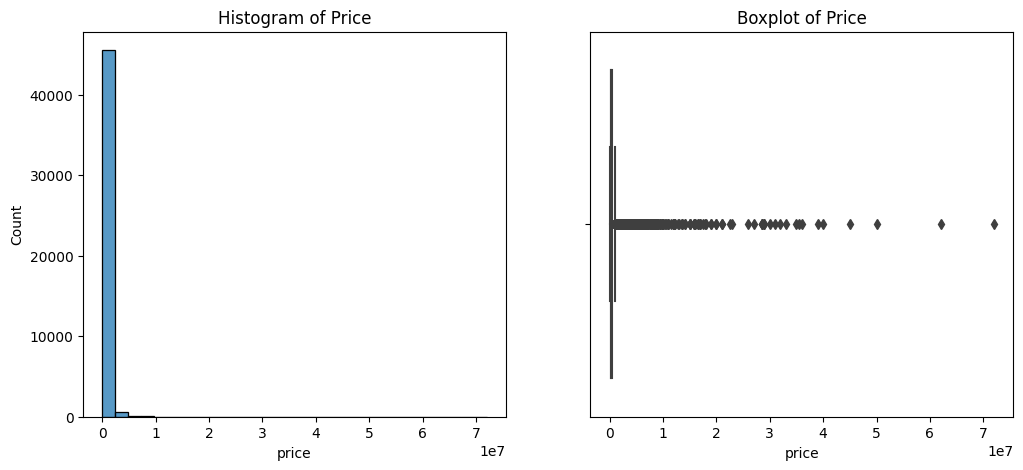

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.histplot(data=df, x="price", bins=30, ax=axs[0])
sns.boxplot(data=df, x="price", ax=axs[1])

axs[0].set_title("Histogram of Price")
axs[1].set_title("Boxplot of Price")

In [13]:
# price needs a log transformation for better viz and processing
log_price = np.log(df["price"])
df["log_price"] = np.log(df.loc[:, "price"])

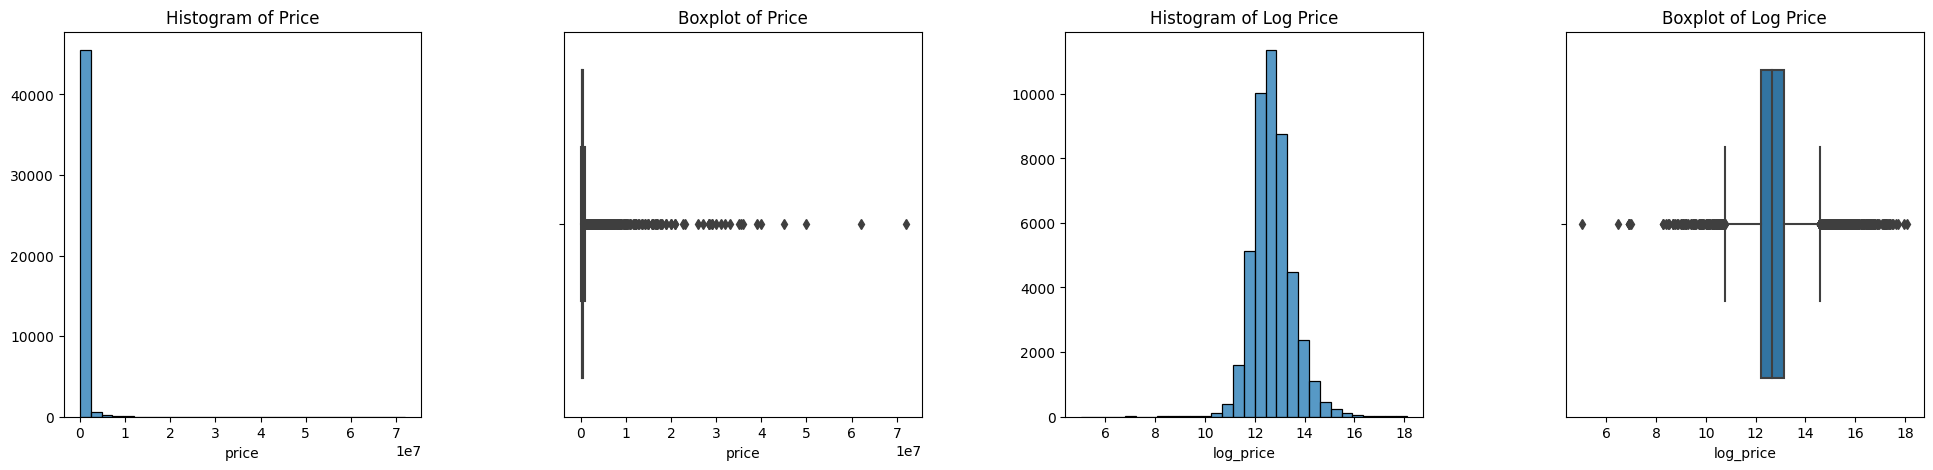

In [14]:
## LATEX PLOT
fig, axs = plt.subplots(ncols=4, figsize=(24,5))

sns.histplot(data=df, x="price", bins=30, ax=axs[0])
sns.boxplot(data=df, x="price", ax=axs[1])

sns.histplot(data=df, x="log_price", bins=30, ax=axs[2])
sns.boxplot(data=df, x="log_price", ax=axs[3])

axs[0].set_title("Histogram of Price")
axs[1].set_title("Boxplot of Price")

axs[2].set_title("Histogram of Log Price")
axs[3].set_title("Boxplot of Log Price")

axs[0].set(ylabel=None)
axs[2].set(ylabel=None)
plt.subplots_adjust(wspace=0.4)

plt.savefig(cwd / "processed" / "price.png", dpi=300)

## Overview on correlations

In [15]:
col_to_types = dict(df.dtypes)
num_cols = [col for col, dtype in col_to_types.items() if dtype != "O"]
cat_cols = [col for col, dtype in col_to_types.items() if dtype == "O"]

In [16]:
corr_matrix = df[num_cols].corr()
corr_matrix

,price,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price
price,1.000000,-0.146158,0.042099,-0.058596,-0.001102,0.011623,0.033973,0.508281,0.010874,-0.001927,0.232072,0.031700,0.360659,0.566198
construction_year,-0.146158,1.000000,-0.106441,-0.001433,0.005761,0.005603,0.014609,-0.002819,NaN,0.000973,-0.076298,-0.019206,-0.082983,-0.208794
latitude,0.042099,-0.106441,1.000000,-0.745228,-0.004700,0.012065,-0.028080,-0.059336,-0.177837,0.008444,-0.003630,0.027972,-0.034341,0.111106
longitude,-0.058596,-0.001433,-0.745228,1.000000,0.004332,-0.017770,-0.069229,0.082804,-0.083905,0.000682,0.191809,-0.052138,0.069755,-0.144780
energy_efficiency,-0.001102,0.005761,-0.004700,0.004332,1.000000,-0.000284,-0.006334,-0.005058,0.001313,0.008482,-0.006396,0.001050,-0.003902,-0.000886
expenses,0.011623,0.005603,0.012065,-0.017770,-0.000284,1.000000,0.002535,0.005726,NaN,0.014227,0.003754,0.005259,0.007023,0.017036
floor,0.033973,0.014609,-0.028080,-0.069229,-0.006334,0.002535,1.000000,-0.006858,0.128573,0.005267,-0.013004,0.018728,-0.034006,0.077057
n_bathrooms,0.508281,-0.002819,-0.059336,0.082804,-0.005058,0.005726,-0.006858,1.000000,0.010847,-0.005369,0.518074,-0.016441,0.681066,0.553816
elevator,0.010874,NaN,-0.177837,-0.083905,0.001313,NaN,0.128573,0.010847,1.000000,NaN,-0.097501,-0.012090,0.006641,-0.012711
total_floors,-0.001927,0.000973,0.008444,0.000682,0.008482,0.014227,0.005267,-0.005369,NaN,1.000000,0.008480,0.001467,-0.002761,-0.004308


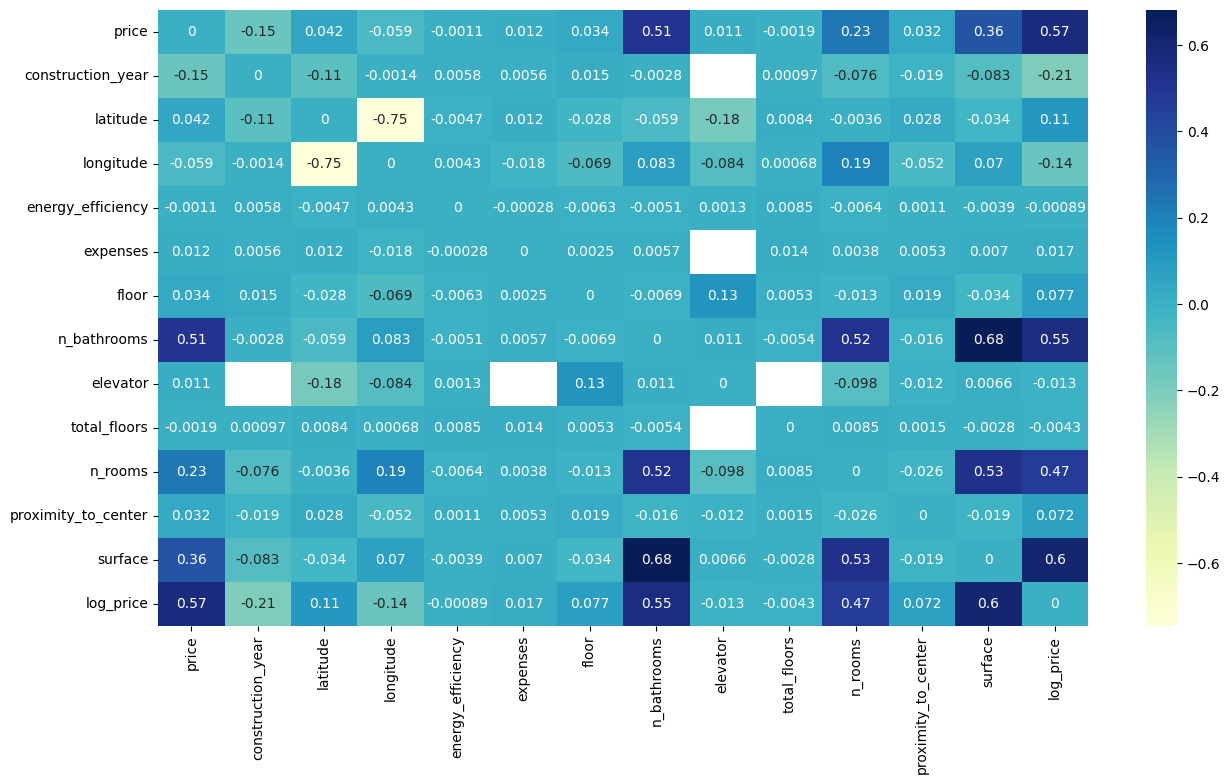

In [17]:
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix - np.eye(corr_matrix.shape[0]), annot=True, cmap="YlGnBu")
plt.show()

In [18]:
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
log_price              0.566198
n_bathrooms            0.508281
surface                0.360659
n_rooms                0.232072
latitude               0.042099
floor                  0.033973
proximity_to_center    0.031700
expenses               0.011623
elevator               0.010874
energy_efficiency     -0.001102
total_floors          -0.001927
longitude             -0.058596
construction_year     -0.146158
Name: price, dtype: float64

In [19]:
def get_corr(feature):
    corr_matrix = df[["price", feature]].corr()
    corr = np.around(corr_matrix.loc["price", feature], 4)
    print(f"corr {corr}")

the most correlated variable with price is the number of bathrooms. We then have surface and number of rooms. All of the three suggest in some way that bigger houses are associated to higher prices.

## Overview on missing data

In [20]:
print(f"{df.size} entries of which {df.isna().sum().sum()} are nans.")
print(f"Percentage of nans {100 * df.isna().sum().sum() / df.size:.2f}%")
nan_df = pd.DataFrame()
nan_df["num_nan"] = df.isna().sum() 
nan_df["perc_nans"] = 100 * np.round(df.isna().sum() / df.shape[0], 4)
nan_df

787304 entries of which 139278 are nans.
Percentage of nans 17.69%


,num_nan,perc_nans
price,0,0.00
balcony,15443,33.35
conditions,1229,2.65
construction_year,13946,30.11
latitude,13,0.03
longitude,13,0.03
energy_efficiency,19903,42.98
expenses,16154,34.88
floor,2031,4.39
garden,31529,68.08


<Axes: ylabel='Count'>

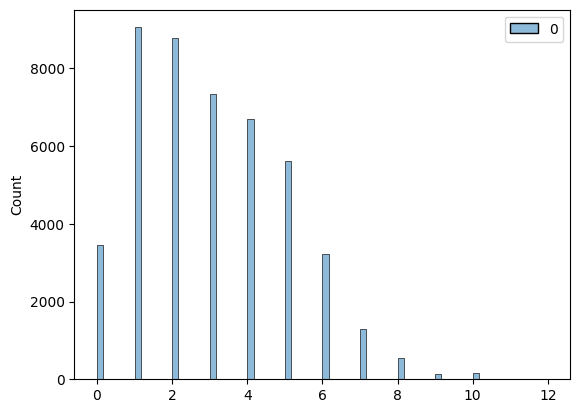

In [21]:
nan_per_row = pd.DataFrame(df.isna().sum(axis=1))
sns.histplot(nan_per_row)

In [22]:
def get_nan(feature):
    nan_df["num_nan"] = df.isna().sum() 
    nan_df["perc_nans"] = 100 * np.round(df.isna().sum() / df.shape[0], 4)
    num = nan_df.loc[feature, :][0]
    perc = nan_df.loc[feature, :][1]
    print(f"{num} nans, {perc:.2f}%")

the dataframe misses a good proportion of the data, around 17% percent. most rows miss from 1 to 4 entries. We will have to deal with this

## Geographic information

one of the most important features we are provided with is for sure the coordinates of the house. We want have an insight on the main location of the houses in the dataset

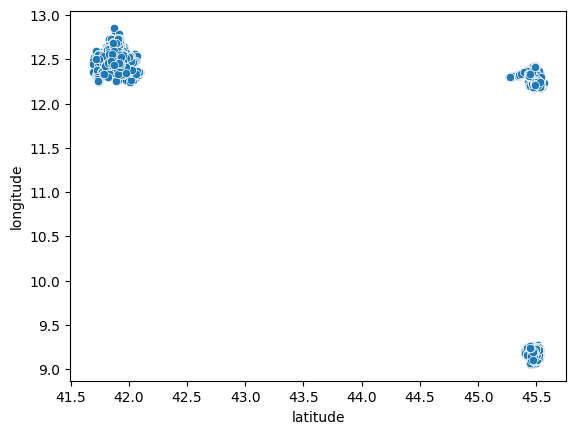

In [23]:
sns.scatterplot(data=df, x="latitude", y="longitude")
plt.show()

the houses seem located in three main clusters

In [24]:
# perform k-means with 3 clusters on the cities

n_clusters = 3

coords_df = df.copy()
coords_df = coords_df[coords_df["latitude"].notna()]

coords = coords_df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(coords)
coords_df['city'] = kmeans.labels_

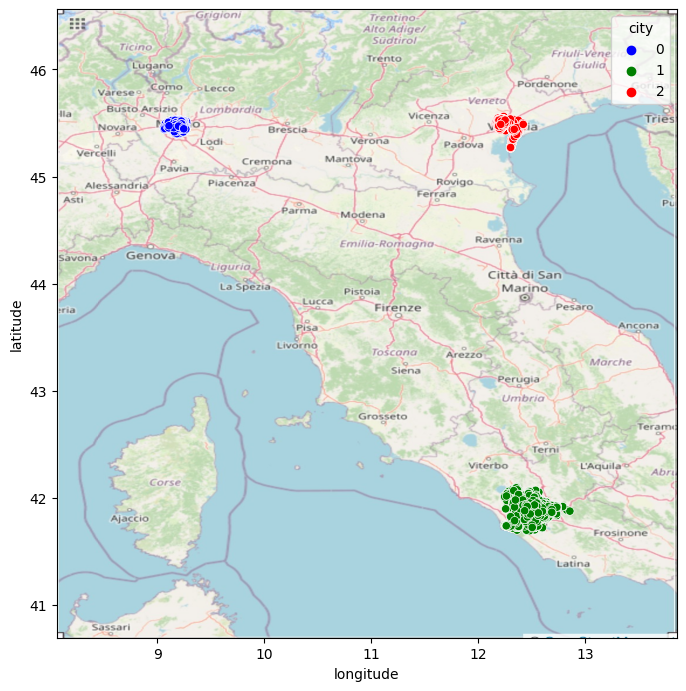

In [25]:
# represent cities on italian map to get idea on the  location

image = mpimg.imread(cwd / "processed" / "italy.jpeg")

fig = plt.figure(figsize=(8,10))
plt.imshow(image, extent=[8.0607, 13.8541, 40.6903, 46.5612])
sns.scatterplot(data=coords_df, x='longitude', y='latitude', hue='city', palette=['blue', 'green', 'red'])

plt.savefig(cwd / "processed" / "clusters.png", dpi=300)
plt.show()

the three main cities seem to be Milan, Rome and Venice. We can also check the distribution of houses in the cities.

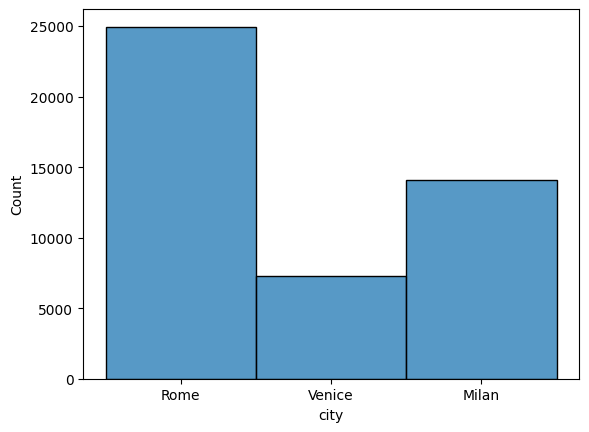

In [26]:
cities_map = {0: "Milan", 1: "Rome", 2: "Venice"}
coords_df["city"] = coords_df["city"].apply(lambda x: cities_map[x])
sns.histplot(data=coords_df, x="city")
plt.show()

In [27]:
coords_df["city"].value_counts() / coords_df.shape[0]

city
Rome      0.539040
Milan     0.304045
Venice    0.156915
Name: count, dtype: float64

concluding, we have three main cities. Rome 54% Milan 30% and venice 16%

# Data Processing

In [28]:
# decorator that makes sure that no rows are accidentally dropped from a dataframe

def check_length(func):
    
    def wrapper(df, *args, **kwargs):
        input_len = df.shape[0]
        output = func(df, *args, **kwargs)
        output_len = output.shape[0]
        # Check that the lengths match
        if input_len != output_len:
            raise ValueError(f"Input DataFrame has {input_len} rows, but output DataFrame has {output_len} rows.")
        return output
    
    return wrapper

## Missing Values, Outliers & Encoding

Note that we can only drop rows on the train set while not in the test set. Therefore, we will define some functions to be applied to both dataframes, and these will never drop rows. This is when the decorator is used. However, we will also eventually drop some rows from the train, and this will always be printed to that we can check everything went as planned. Moreover, when looking at the features individually, if we want to remove that feature we will append the name of the feature to a list called "to drop" which well be used at the end of the feature augmentation process to drop these features (they are kept up to that point for the purpose of variable interaction).

In [29]:
# list of features that we will drop
to_drop = []

### Price

As already noted in EDA, price contains some weird values. Let's investigate

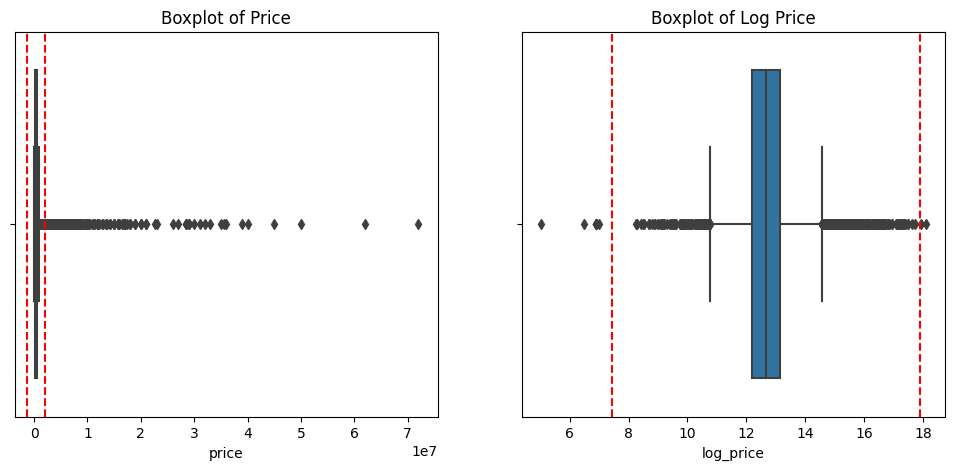

In [30]:
# boxplot of price and log price with extreme quartile range highlighted (q2 - 5*q1, q2 + 5*q3)
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(data=df, x="price", ax=axs[0])
sns.boxplot(data=df, x="log_price", ax=axs[1])

axs[0].set_title("Boxplot of Price")
axs[1].set_title("Boxplot of Log Price")

q1, q3 = np.percentile(df["price"], [25, 75])
qlow = q1 - 5 * (q3 - q1)
qhigh = q3 + 5 * (q3 - q1)
axs[0].axvline(x=qlow, color="red", linestyle="--")
axs[0].axvline(x=qhigh, color="red", linestyle="--")

q1, q3 = np.percentile(df["log_price"], [25, 75])
qlow = q1 - 5 * (q3 - q1)
qhigh = q3 + 5 * (q3 - q1)
axs[1].axvline(x=qlow, color="red", linestyle="--")
axs[1].axvline(x=qhigh, color="red", linestyle="--")

plt.show()

will drop log prices smaller than 8 and prices higher than 50 millions 

In [31]:
shape = df.shape

outliers = df[(df["log_price"] <= 8) | (df["price"] >= 5e7)]
df = df[~df.index.isin(outliers.index)]

print(f"dropped {shape[0] - df.shape[0]} outliers")
outliers

dropped 10 outliers


,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price
id,,,,,,,,,,,,,,,,,
60369,1000.0,True,Ottimo / Ristrutturato,NaN,41.735241,12.259580,180.00,100.0,1.0,NaN,1.0,1.0,NaN,3.0,0.793269,60.0,6.907755
39430,154.0,True,Nuovo / Nuova costruzione,2019.0,41.853586,12.652271,NaN,NaN,NaN,True,2.0,NaN,NaN,5.0,1.000000,119.0,5.036953
62599,1000.0,NaN,Ottimo / Ristrutturato,NaN,45.482689,12.250937,NaN,NaN,2.0,True,3.0,NaN,NaN,5.0,1.000000,190.0,6.907755
9279,1000.0,NaN,NaN,NaN,41.924900,12.489800,175.00,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.000000,150.0,6.907755
46741,650.0,NaN,Buono stato / Abitabile,NaN,45.476200,12.197400,NaN,0.0,3.0,NaN,1.0,NaN,3.0,4.0,1.000000,80.0,6.476972
51786,72000000.0,True,Ottimo / Ristrutturato,1900.0,41.890301,12.493500,175.00,NaN,5.0,NaN,NaN,NaN,1.0,5.0,1.000000,0.0,18.092177
19015,1100.0,NaN,Ottimo / Ristrutturato,1960.0,45.470700,9.236800,118.27,100.0,0.0,NaN,1.0,1.0,6.0,2.0,1.000000,60.0,7.003065
33733,50000000.0,NaN,Nuovo / Nuova costruzione,NaN,45.434280,12.338111,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,17.727534
43580,62000000.0,NaN,NaN,NaN,45.433701,12.338300,NaN,NaN,6.0,NaN,NaN,NaN,1.0,NaN,1.000000,200.0,17.942645


In [32]:
df["price"].describe()

count    4.630200e+04
mean     4.993225e+05
std      9.897305e+05
min      3.900000e+03
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      4.500000e+07
Name: price, dtype: float64

### Balcony

In [33]:
get_nan("balcony")

15436.0 nans, 33.34%


In [34]:
df["balcony"].value_counts()

balcony
True    30866
Name: count, dtype: int64

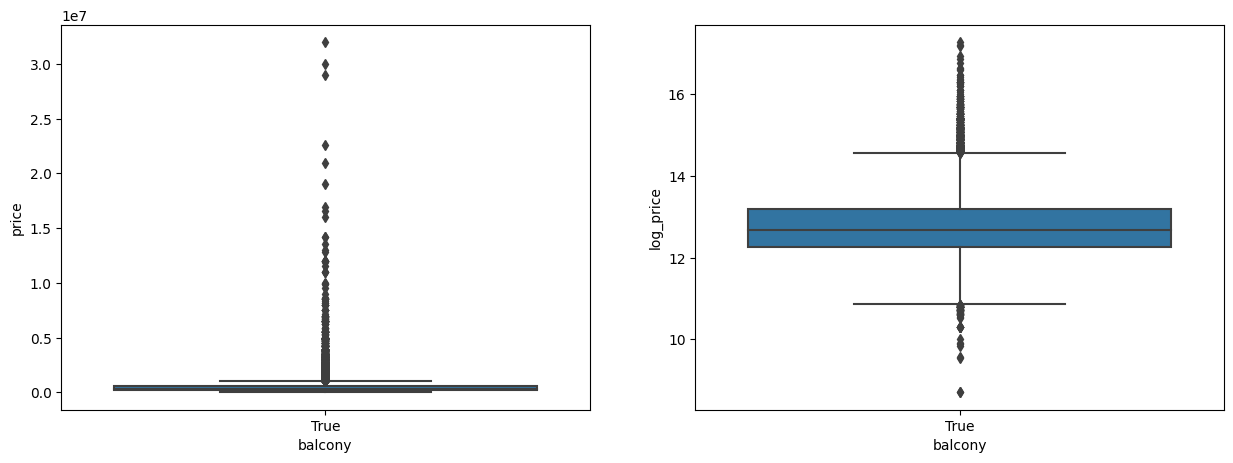

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="balcony", y="price", ax=axs[0])
sns.boxplot(data=df, x="balcony", y="log_price", ax=axs[1])
plt.show()

Balcony lot of missing values. Also, the given values are uniquely true. This suggests that a nan could reflect the absence of a balcony.

In [36]:
@check_length
def impute_balcony(data):
    """Fill balcony missing values with a False"""
    
    data.loc[:, "balcony"] = data["balcony"].fillna(False)
    data["balcony"] = data["balcony"].astype(int)
        
    return data

In [37]:
df = impute_balcony(df)
test = impute_balcony(test)

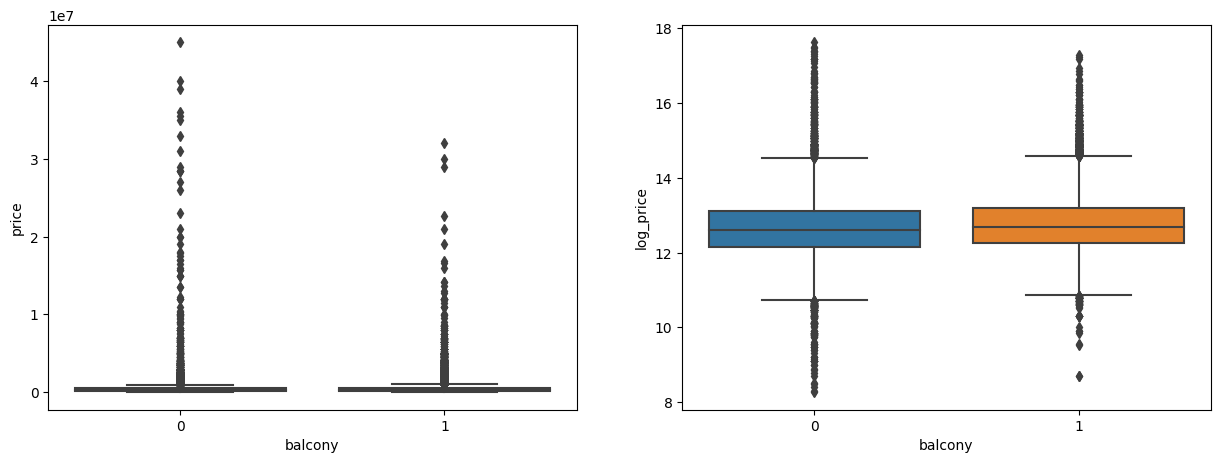

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="balcony", y="price", ax=axs[0])
sns.boxplot(data=df, x="balcony", y="log_price", ax=axs[1])
plt.show()

In [39]:
get_nan("balcony")
get_corr("balcony")

0.0 nans, 0.00%
corr -0.0026


In [40]:
# correlation is very low and we made a big assumption, so i will drop column in a second moment
to_drop.append("balcony")

### Garden

In [41]:
get_nan("garden")

31522.0 nans, 68.08%


In [42]:
df["garden"].value_counts()

garden
True    14780
Name: count, dtype: int64

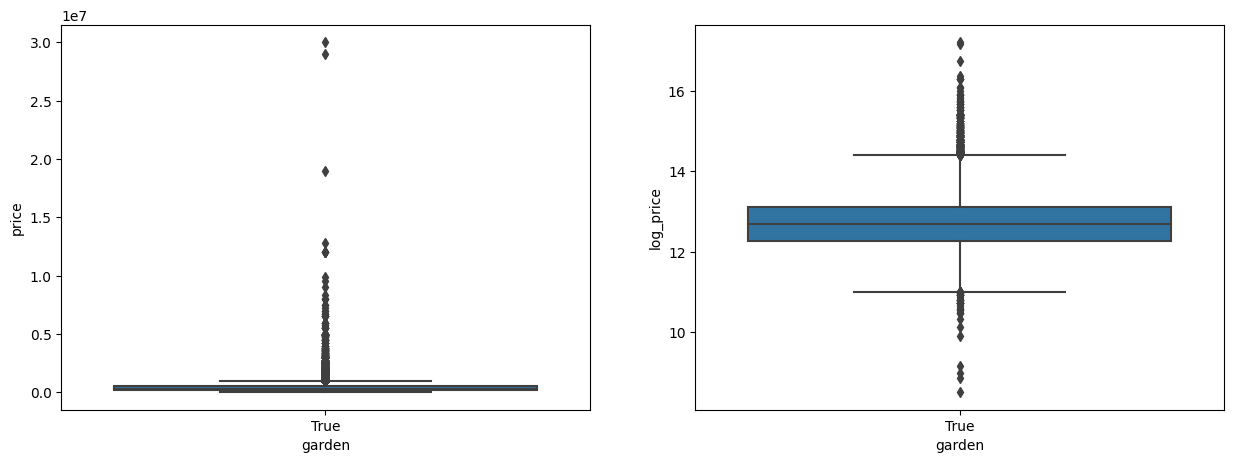

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="garden", y="price", ax=axs[0])
sns.boxplot(data=df, x="garden", y="log_price", ax=axs[1])
plt.show()

the same reasoning as for balcony is true. nan could reflect absence of garden

In [44]:
@check_length
def impute_garden(data):
    "Fill garden missing values with False"
    
    data.loc[:, "garden"] = data["garden"].fillna(False)
    data["garden"] = data["garden"].astype(int)
    return data

In [45]:
df = impute_garden(df)
test = impute_garden(test)

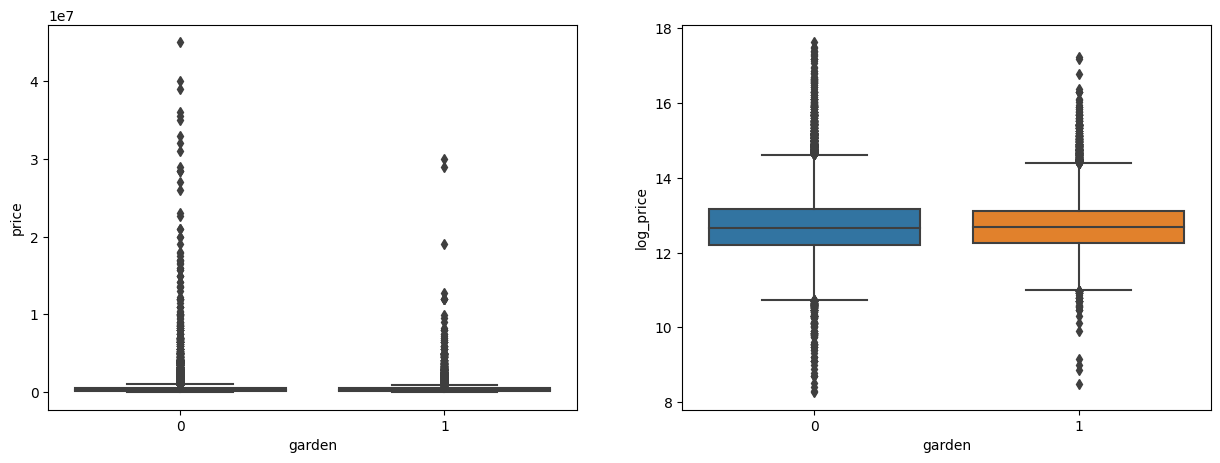

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="garden", y="price", ax=axs[0])
sns.boxplot(data=df, x="garden", y="log_price", ax=axs[1])
plt.show()

In [47]:
get_nan("garden")
get_corr("garden")

0.0 nans, 0.00%
corr -0.0127


In [48]:
# big assumption and low correlation -> will drop garden too
to_drop.append("garden")

### Conditions

In [49]:
get_nan("conditions")

1227.0 nans, 2.65%


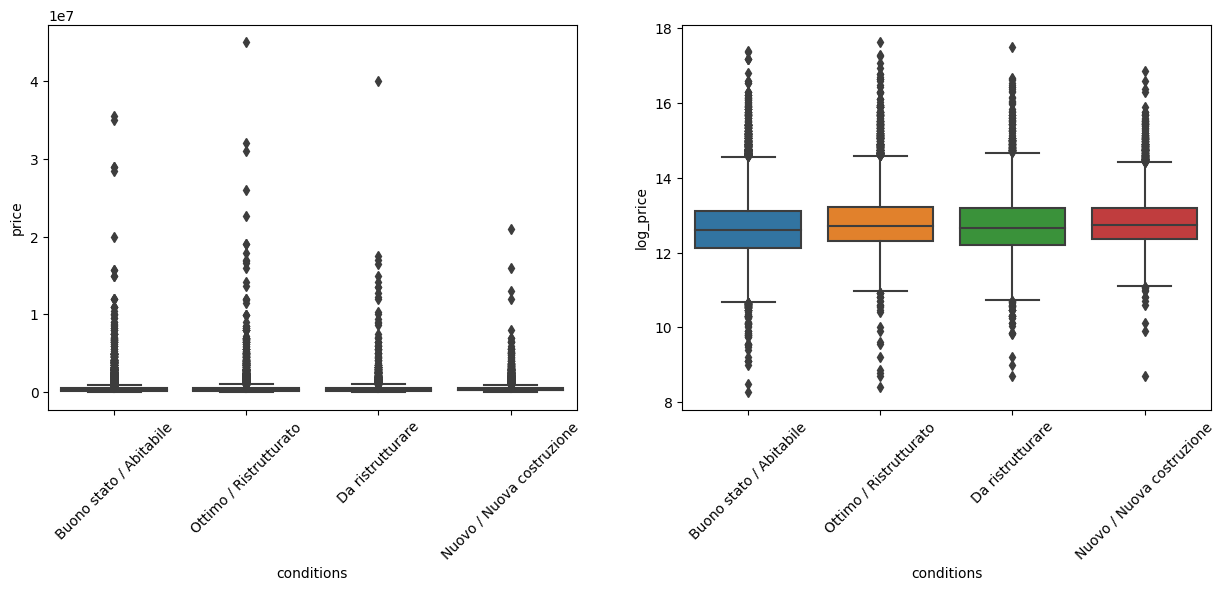

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="conditions", y="price", ax=axs[0])
sns.boxplot(data=df, x="conditions", y="log_price", ax=axs[1])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
plt.show()

In [51]:
df["conditions"].value_counts()

conditions
Buono stato / Abitabile      21826
Ottimo / Ristrutturato       10528
Nuovo / Nuova costruzione     7043
Da ristrutturare              5678
Name: count, dtype: int64

In [52]:
# Fill the missing values with a categorical flag

@check_length
def impute_conditions(data):
    "Fill condition missing values with flag"
        
    data["conditions"].fillna("Missing Value", inplace=True)
    
    return data 

In [53]:
df = impute_conditions(df)
test = impute_conditions(test)

In [54]:
df.groupby(by="conditions")["price"].median()

conditions
Buono stato / Abitabile      295000.0
Da ristrutturare             315000.0
Missing Value                278000.0
Nuovo / Nuova costruzione    340000.0
Ottimo / Ristrutturato       330000.0
Name: price, dtype: float64

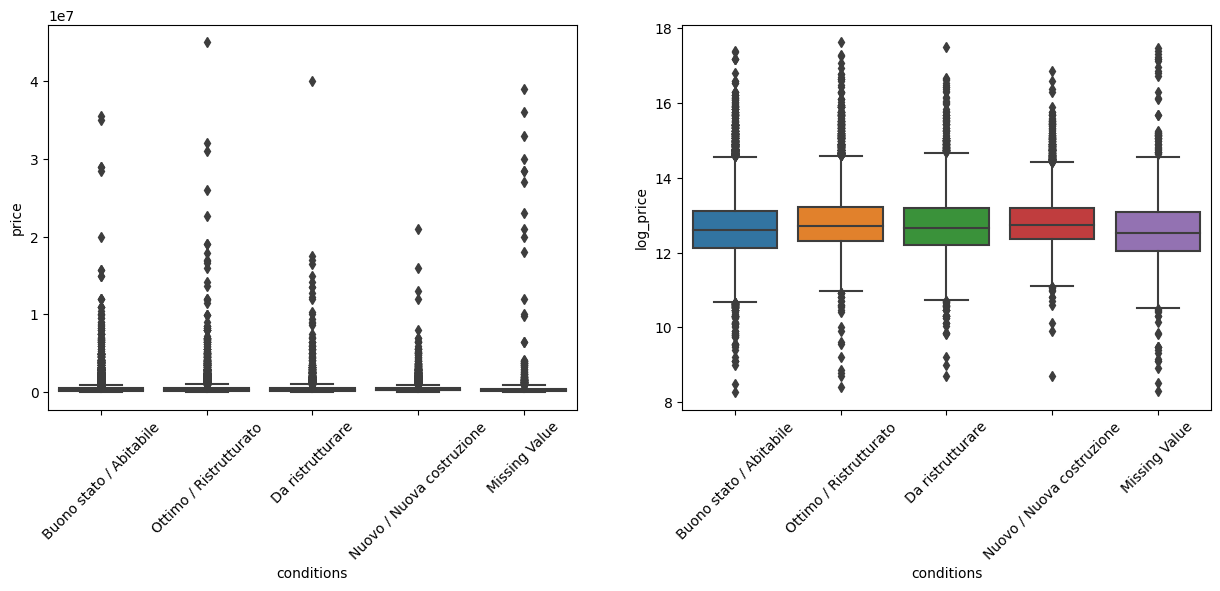

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=df, x="conditions", y="price", ax=axs[0])
sns.boxplot(data=df, x="conditions", y="log_price", ax=axs[1])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
plt.show()

In [56]:
# define ordinal imputer manually basing on values from prev analysis on conditions
conditions_imputer = {
    "Missing Value": 0,
    "Da ristrutturare": 1,
    "Buono stato / Abitabile": 2, 
    "Ottimo / Ristrutturato": 3,
    "Nuovo / Nuova costruzione": 4,
}

@check_length
def encode_conditions(data):
    "Encode conditions using ordinal imputer"
    
    data["conditions"] = data["conditions"].replace(conditions_imputer)
    
    return data

In [57]:
df = encode_conditions(df)
test = encode_conditions(test)

### City (lat and lng)

In [58]:
get_nan("latitude")
get_nan("longitude")

13.0 nans, 0.03%
13.0 nans, 0.03%


this is a crucial missing information. since we only have 13 rows missing the information, I will drop these rows. I do not want to impute with some values that might classify a house in the wrong city

In [59]:
df = df[df["latitude"].notna()]

In [60]:
test["latitude"].isna().sum()

10

however, we also have some missing values in the test. we cannot drop these rows, so we must find a strategy to impute them using train data.

In [61]:
# define simple imputer using the train median coordinates (this will yield 10 houses in Rome)
lat_imputer = SimpleImputer(strategy="median")
lng_imputer = SimpleImputer(strategy="median")
lat_imputer.fit(df.loc[:, ["latitude"]])
lng_imputer.fit(df.loc[:, ["longitude"]])

@check_length
def impute_coordinates(data, add=False):
    """Fill missing coordinates with median from train"""
    
    data["latitude"] = lat_imputer.transform(data.loc[:, ["latitude"]])[:,0]
    data["longitude"] = lng_imputer.transform(data.loc[:, ["longitude"]])[:,0]
    
    return data

In [62]:
# df = impute_coordinates(df)  # we dropped the null from here
test = impute_coordinates(test)

now turn to the correlations

In [63]:
get_corr("latitude")
get_corr("longitude")

corr 0.046
corr -0.068


it seems they have no correlation with price because the information is encoded.
try to decode

Process the coordinates to get the closest city

In [64]:
city_df = pd.read_csv(cwd / "processed" / "maps_city.csv", index_col="city")

In [65]:
city_df.head(10)  # this df contains the 100 biggest cities in italy by population

,lat,lng
city,,
Rome,41.8931,12.4828
Milan,45.4669,9.1900
Naples,40.8333,14.2500
Turin,45.0792,7.6761
Palermo,38.1157,13.3613
Genoa,44.4111,8.9328
Bologna,44.4939,11.3428
Florence,43.7714,11.2542
Bari,41.1253,16.8667


In [66]:
# functions to find closest city using coordinates
def get_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))

def get_closest_city(house_df, data):
    house_df = np.broadcast_to(house_df, (data.shape[0], 2))
    dist_mat = get_distance(data.lat, data.lng, house_df[:, 0], house_df[:, 1])
    city_id = np.argmin(dist_mat)
    d = dist_mat[city_id]
    return data.iloc[city_id].name, d

def add_city(data, city_df, with_distance=True):
    v = []
    for house_coords in data[["latitude", "longitude"]].values:
        v.append(get_closest_city(house_coords, city_df))
    if with_distance:
        data[["city", "distance_from_center"]] = v
        data["distance_from_center"] = data["distance_from_center"].astype(float) 
    else:
        data["city"] = np.array(v)[:, 0]
    return data

In [67]:
df_copy = df.copy()
df_copy = add_city(df_copy, city_df)

In [68]:
df_copy.head(3)

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price,city,distance_from_center
id,,,,,,,,,,,,,,,,,,,
10461,60000.0,1,2,1980.0,41.901300,12.700000,175.0,30.0,2.0,0,1.0,NaN,3.0,1.0,1.0,35.0,11.002100,Rome,18.000160
51304,900000.0,0,2,NaN,41.907017,12.481311,NaN,NaN,3.0,0,1.0,1.0,NaN,3.0,1.0,131.0,13.710150,Rome,1.552411
33032,33000.0,0,2,1960.0,41.976500,12.440500,204.2,30.0,4.0,0,1.0,NaN,4.0,1.0,1.0,16.0,10.404263,Rome,9.911794


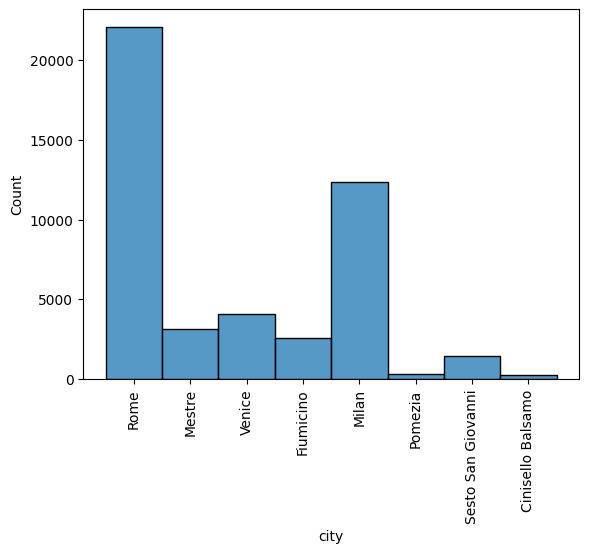

In [69]:
sns.histplot(data=df_copy, x="city")
plt.xticks(rotation=90)
plt.show()

as previously noticed, the houses are clustered around Milan, Venice and Rome.
will only map to closest big city of and get the distance from its center (the coordinates in the above dataframe, which I personally checked if correct for the three cities)

In [70]:
city_df_restricted = city_df.loc[["Rome", "Milan", "Venice"], :]

In [71]:
@check_length
def add_city_distance(data):
    
    """Add city and distance from center as new columns"""
  
    data = add_city(data, city_df_restricted)
        
    return data

In [72]:
df = add_city_distance(df,)
test = add_city_distance(test)

[]

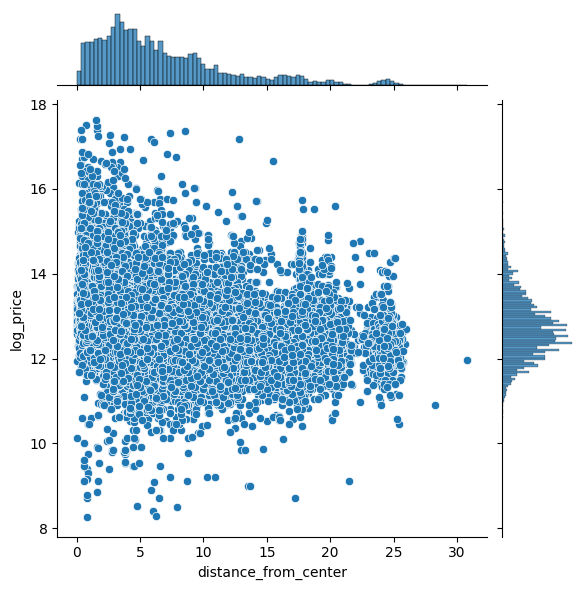

In [73]:
sns.jointplot(data=df, x="distance_from_center", y="log_price")
plt.plot()

In [74]:
encoder = OneHotEncoder(sparse_output=False)

@check_length
def encode_cities(data):

    # encode cities with one hot
    encoded_data = encoder.fit_transform(data[["city"]]).astype(int)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["city"]), index=data.index)
    data = pd.merge(data, encoded_df, how="inner", left_index=True, right_index=True)
    data = data.drop("city", axis=1)
    
    return data


df = encode_cities(df)
test = encode_cities(test)

### Proximity to center

In [75]:
get_nan("proximity_to_center")
get_corr("proximity_to_center")

0.0 nans, 0.00%
corr 0.0347


In [76]:
df["proximity_to_center"].value_counts()

proximity_to_center
1.000000    44285
0.875523       12
0.904928       12
0.906552       12
0.845462        9
            ...  
0.938972        1
0.774114        1
0.861400        1
0.923919        1
0.794258        1
Name: count, Length: 1638, dtype: int64

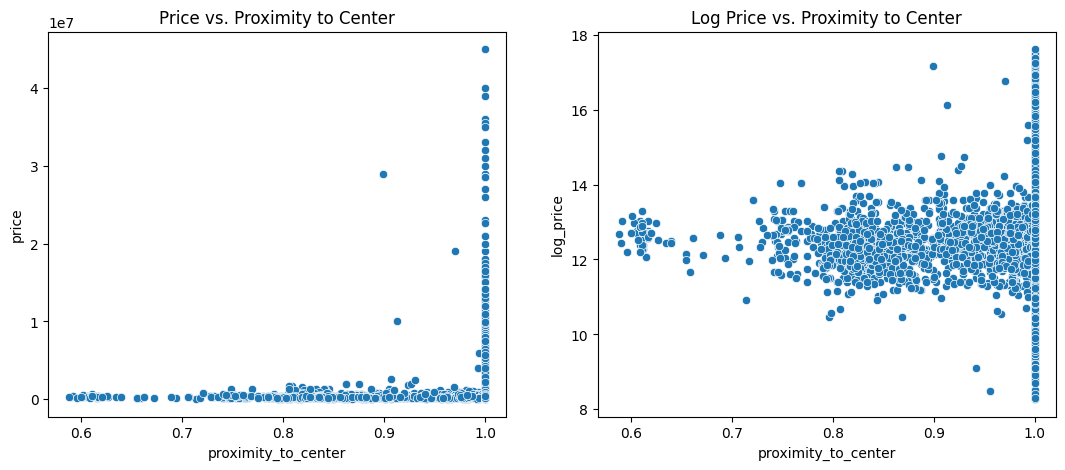

In [77]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 5))
sns.scatterplot(data=df, x="proximity_to_center", y="price", ax=axs[0])
sns.scatterplot(data=df, x="proximity_to_center", y="log_price", ax=axs[1])
axs[0].set_title("Price vs. Proximity to Center")
axs[1].set_title("Log Price vs. Proximity to Center")
plt.show()

In [78]:
test["proximity_to_center"].isna().sum()

10

very few missing values (0 on train, 10 on test) so I'll me happy with mode imputing (=1) 

In [79]:
imputer = SimpleImputer(strategy="most_frequent")  # very few missing values so I'll me happy with mode imputing (=1)
imputer.fit(df.loc[:, ["proximity_to_center"]])  


def impute_proximity(data):
    "Fill proximity missing values with mode from train"
    
    data["proximity_to_center"] = imputer.transform(data.loc[:, ["proximity_to_center"]])[:, 0]
    
    return data

In [80]:
test = impute_proximity(test)  # no need to impute on train as it is clean

### Construction Year

In [81]:
get_nan("construction_year")
get_corr("construction_year")

13933.0 nans, 30.10%
corr -0.1647


In [82]:
df["construction_year"].describe()

count    32356.000000
mean      1958.034244
std         72.029968
min       1000.000000
25%       1950.000000
50%       1967.000000
75%       1987.000000
max       2500.000000
Name: construction_year, dtype: float64

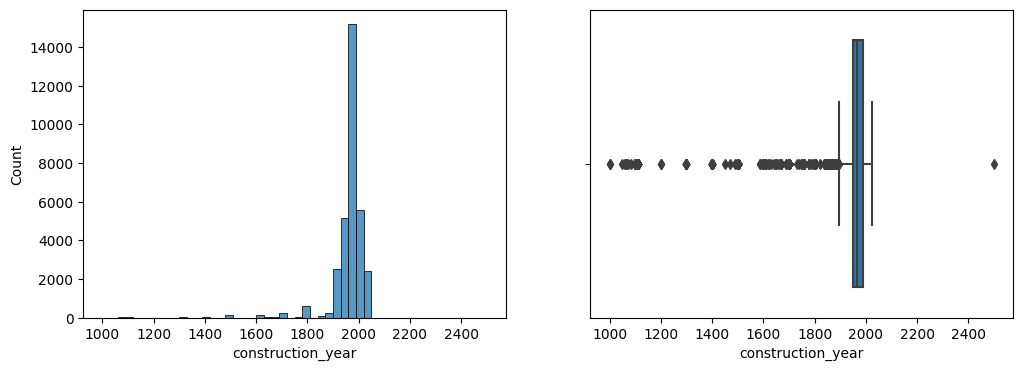

In [83]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sns.histplot(data=df, x="construction_year", bins=50, ax=axs[0])
sns.boxplot(data=df, x="construction_year", ax=axs[1])
plt.show()

In [84]:
df.sort_values("construction_year", ascending=False)["construction_year"][:5]

id
6258     2500.0
6332     2025.0
28222    2025.0
25222    2025.0
11075    2025.0
Name: construction_year, dtype: float64

In [85]:
df[df["construction_year"] > 2023]["conditions"].value_counts()

conditions
4    140
2      2
Name: count, dtype: int64

this suggests that houses built in 2024/2025 have the condition new, so i assume they are being built. however, 2500 (just one) is clearly outlier

In [86]:
outliers = df[df["construction_year"] > 2025]
df = df[~df.index.isin(outliers.index)]

print(f"dropped {outliers.shape[0]} outlier(s)")
outliers

dropped 1 outlier(s)


,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price,distance_from_center,city_Milan,city_Rome,city_Venice
id,,,,,,,,,,,,,,,,,,,,,
6258,145000.0,0,2,2500.0,45.497383,12.253994,NaN,200.0,1.0,0,1.0,NaN,NaN,6.0,1.0,98.0,11.884489,8.834484,0,0,1


given that construction year has a nice correlation with price i will use KNN imputing with so that missing values are placed with values from similar houses on the train set

In [87]:
imputer = KNNImputer(n_neighbors=5)
knn_cols = ["construction_year"] + [col for col in test.columns if col != "construction_year"]  # do not include price
imputer.fit(df[knn_cols])  # use also "latitude", "longitude"]])


@check_length
def proc_year(data):
    """Fill construction year missing values using 5-NN fitted on the train"""
    
    data["construction_year"] = imputer.transform(data[knn_cols])[:, 0]
    data["construction_year"] = data["construction_year"].astype(int)
    
    return data

In [88]:
df = proc_year(df)
test = proc_year(test)

In [89]:
get_nan("construction_year")
get_corr("construction_year")

0.0 nans, 0.00%
corr -0.1157


### Energy Eficiency

In [90]:
get_nan("energy_efficiency")
get_corr("energy_efficiency")

19884.0 nans, 42.96%
corr -0.0012


In [91]:
df["energy_efficiency"].value_counts()

energy_efficiency
175.00    15702
3.51       2487
180.00      249
1.00        176
212.00      145
          ...  
190.64        1
161.47        1
327.56        1
199.02        1
269.17        1
Name: count, Length: 4010, dtype: int64

<Axes: xlabel='energy_efficiency'>

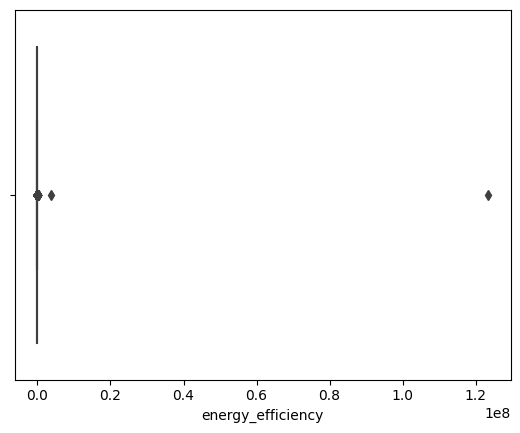

In [92]:
sns.boxplot(data=df, x="energy_efficiency")

In [93]:
df.sort_values("energy_efficiency", ascending=False)["energy_efficiency"]

id
15981    123457000.0
65664      3727500.0
49356       269910.0
4947        252367.0
61321       233250.0
            ...     
46810            NaN
63289            NaN
17403            NaN
33332            NaN
63367            NaN
Name: energy_efficiency, Length: 46288, dtype: float64

this feature has some crazy high values, many outliers and many null values. I'll impute with median and append in the columns to be dropped

In [94]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df.loc[:, ["energy_efficiency"]])


@check_length
def proc_energy(data):
    
    data["energy_efficiency"] = imputer.transform(data.loc[:, ["energy_efficiency"]])[:,0]
    
    return data

In [95]:
df = proc_energy(df)
test = proc_energy(test)

In [96]:
to_drop.append("energy_efficiency")

### Total Floors

In [97]:
get_nan("total_floors")
get_corr("total_floors")

18330.0 nans, 39.60%
corr -0.0021


In [98]:
df["total_floors"].value_counts()[:10]

total_floors
5.0     5570
4.0     5516
3.0     4448
2.0     3318
6.0     2748
7.0     2127
8.0     1985
1.0     1440
9.0      446
10.0     107
Name: count, dtype: int64

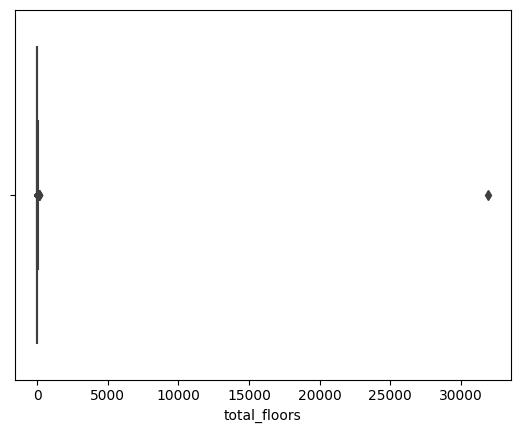

In [99]:
sns.boxplot(data=df, x="total_floors")
plt.show()

In [100]:
df.sort_values("total_floors", ascending=False)["total_floors"]

id
38776    31960.0
52436      135.0
56531      109.0
9228       100.0
63778       99.0
          ...   
58392        NaN
46810        NaN
17403        NaN
33332        NaN
63367        NaN
Name: total_floors, Length: 46288, dtype: float64

this feature also contains many outliers and many missing values. I will use median imputing and append to be dropped

In [101]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df.loc[:, ["total_floors"]])


@check_length
def proc_floors(data):
    
    data["total_floors"] = imputer.transform(data.loc[:, ["total_floors"]])[:,0]
    data["total_floors"] = data["total_floors"].astype(int)
    
    return data

In [102]:
df = proc_floors(df)
test = proc_floors(test)

In [103]:
get_nan("total_floors")
get_corr("total_floors")

0.0 nans, 0.00%
corr -0.0017


In [104]:
to_drop.append("total_floors")

### Expenses

In [105]:
get_nan("expenses")
get_corr("expenses")

16139.0 nans, 34.87%
corr 0.0116


In [106]:
df["expenses"].describe()

count     30149.000000
mean        195.294670
std        4035.610197
min           0.000000
25%          40.000000
50%          80.000000
75%         150.000000
max      346000.000000
Name: expenses, dtype: float64

In [107]:
df["expenses"].value_counts()

expenses
0.0         3950
100.0       2287
50.0        2149
60.0        1215
150.0       1137
            ... 
435.0          1
250000.0       1
3800.0         1
3300.0         1
984.0          1
Name: count, Length: 492, dtype: int64

In [108]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df.loc[:, ["expenses"]])
    
    
@check_length
def proc_expenses(data):
    
    data["expenses"] = imputer.transform(data.loc[:, ["expenses"]])[:,0]
    
    return data

In [109]:
df = proc_expenses(df)
test = proc_expenses(test)

In [110]:
get_nan("expenses")
get_corr("expenses")

0.0 nans, 0.00%
corr 0.0052


In [111]:
to_drop.append("expenses")  # many missing values and low correlation -> drop

### Number of Rooms

In [112]:
get_nan("n_rooms")
get_corr("n_rooms")

350.0 nans, 0.76%
corr 0.2465


In [113]:
# will impute using regression of n_rooms on surface (reverse case from before)
imputer = SimpleImputer(strategy="median")    
imputer.fit(df.loc[:, ["n_rooms"]])

@check_length
def proc_rooms(data):
    """Fill missing number of rooms with median"""
    
    data["n_rooms"] = imputer.transform(data.loc[:, ["n_rooms"]])[:,0]
    data["n_rooms"] = data["n_rooms"].astype(int)
    
    return data

In [114]:
df = proc_rooms(df)
test = proc_rooms(test)

In [115]:
get_nan("n_rooms")
get_corr("n_rooms")

0.0 nans, 0.00%
corr 0.2119


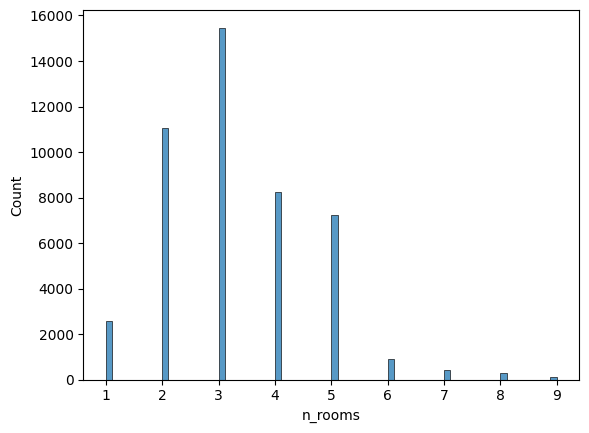

In [116]:
sns.histplot(data=df, x="n_rooms")
plt.show()

### Bathrooms

In [117]:
get_nan("n_bathrooms")
get_corr("n_bathrooms")

2412.0 nans, 5.21%
corr 0.5084


In [118]:
df["n_bathrooms"].value_counts()

n_bathrooms
1.0    24689
2.0    15074
3.0     3449
4.0      374
5.0      133
6.0       82
7.0       47
9.0       16
8.0       12
Name: count, dtype: int64

[]

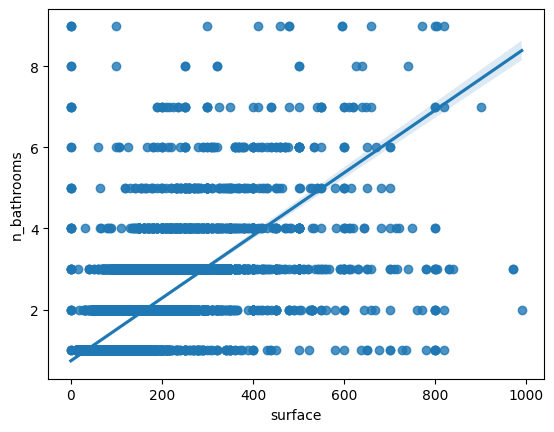

In [119]:
sns.regplot(data=df, x="surface", y="n_bathrooms")
plt.plot()

I will again exploit this linear correlation

In [120]:
imputer = SimpleImputer(strategy="median")    
imputer.fit(df.loc[:, ["n_bathrooms"]])

@check_length
def proc_bathrooms(data):
    """Fill missing bathrooms with median"""
    
    data["n_bathrooms"] = imputer.transform(data.loc[:, ["n_bathrooms"]])[:,0]
    data["n_bathrooms"] = data["n_bathrooms"].astype(int)
    
    return data

In [121]:
df = proc_bathrooms(df)
test = proc_bathrooms(test)

In [122]:
get_nan("n_bathrooms")
get_corr("n_bathrooms")

0.0 nans, 0.00%
corr 0.1861


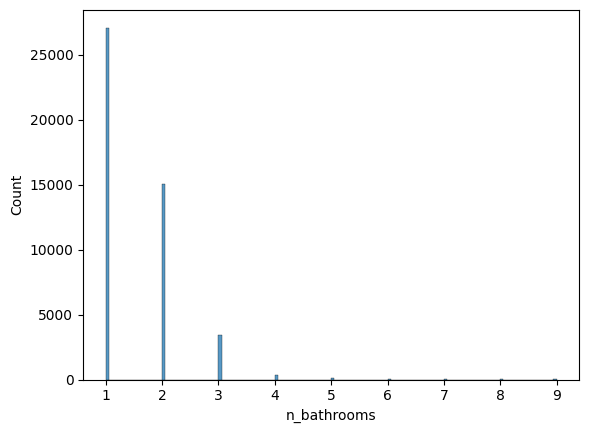

In [123]:
sns.histplot(data=df, x="n_bathrooms")
plt.show()

### Surface

In [124]:
get_nan("surface")
get_corr("surface")

443.0 nans, 0.96%
corr 0.4055


In [125]:
# this information is very valuable and we need some smart way of imputing the missing values
# want to exploit relation between surface and number of rooms, which should be logically linear!

In [126]:
df[["surface", "n_rooms", "n_bathrooms"]].corr()

,surface,n_rooms,n_bathrooms
surface,1.000000,0.506390,0.435773
n_rooms,0.506390,1.000000,0.469371
n_bathrooms,0.435773,0.469371,1.000000


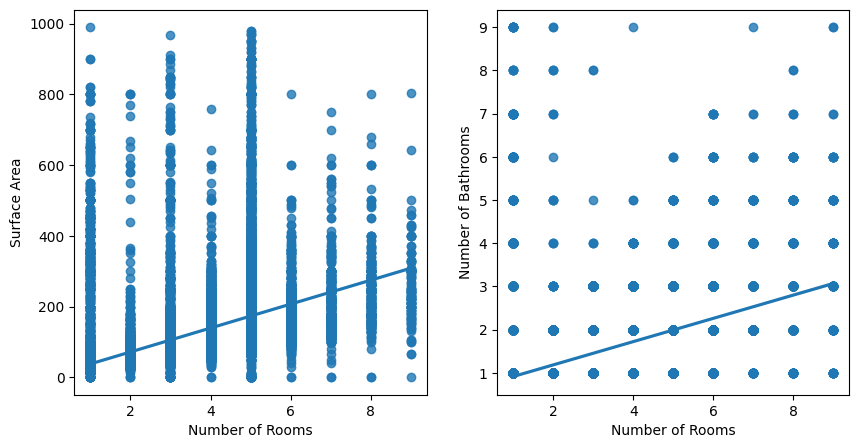

In [127]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

sns.regplot(data=df, x="n_rooms", y="surface", ax=axs[0])
axs[0].set_xlabel("Number of Rooms")
axs[0].set_ylabel("Surface Area")

sns.regplot(data=df, x="n_rooms", y="n_bathrooms", ax=axs[1])
axs[1].set_xlabel("Number of Rooms")
axs[1].set_ylabel("Number of Bathrooms")

plt.show()

In [128]:
df.loc[df["surface"].notna(), ["n_rooms", "n_bathrooms"]]

,n_rooms,n_bathrooms
id,,
10461,1,1
51304,3,1
33032,1,1
62281,2,1
45681,3,2
...,...,...
33085,3,1
17403,5,2
33332,3,2


In [129]:
# define inputer with linear regression on train data using n rooms
reg_imputer = LinearRegression()
X_train = df.loc[df["surface"].notna(), ["n_rooms", "n_bathrooms"]]
y_train = df.loc[df["surface"].notna(), "surface"]
reg_imputer.fit(X_train, y_train)


@check_length
def proc_surface(data):
    """Fill missing surface with regression if n_rooms not null, else with median"""
    
    X_test = data.loc[data["surface"].isna(), ["n_rooms", "n_bathrooms"]]
    data.loc[data["surface"].isna(), "surface"] = reg_imputer.predict(X_test)
    
    return data

In [130]:
df = proc_surface(df)
test = proc_surface(test)

In [131]:
get_nan("surface")
get_corr("surface")  # correlation has not changed nice job !

0.0 nans, 0.00%
corr 0.4051


NOTE!! some houses have a surface of 0

In [132]:
df[df["surface"] == 0].shape

(95, 21)

although these could be imputed with a nan and then imputed with the regression as above, this seem some particular cases rather than "outliers" or "missing values". Indeed, having a surface of zero has a nice correlation with the price, and these houses have on avergae higher prices than the rest of the houses, as shown below

In [133]:
avg_price_0 = np.mean(df[df["surface"] == 0]["price"])
avg_price_normal = np.mean(df[df["surface"] != 0]["price"])

print(f"avg price for surface = 0: {avg_price_0}")
print(f"avg price for surface != 0: {avg_price_normal}")

avg price for surface = 0: 6247798.947368421
avg price for surface != 0: 487486.1755460784


In [134]:
dummy = df.copy()
dummy["flag"] = (df["surface"] == 0)
dummy[["price", "flag"]].corr()

,price,flag
price,1.000000,0.263363
flag,0.263363,1.000000


I will deal with these cases in the feature augmentation section, but I prefer not to drop such rows as there might be some hidden explanation

### Floor

In [135]:
get_corr("floor")
get_nan("floor")

corr 0.0344
2029.0 nans, 4.38%


In [136]:
df["floor"].value_counts()[:5]

floor
 1.0    9866
 2.0    7568
 3.0    5957
 0.0    5831
-1.0    4925
 4.0    4259
 5.0    2677
Name: count, dtype: int64

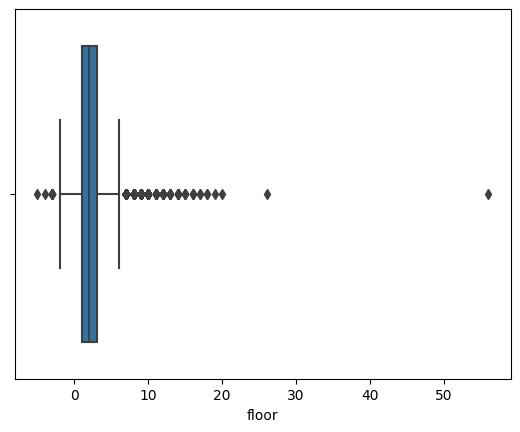

In [137]:
sns.boxplot(data = df, x="floor")
plt.show()

In [138]:
outliers = df[df["floor"] > 50]  # highest building in italy
df = df[~df.index.isin(outliers.index)]

print(f"dropped {outliers.shape[0]} outlier(s)")
outliers

dropped 1 outlier(s)


,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price,distance_from_center,city_Milan,city_Rome,city_Venice
id,,,,,,,,,,,,,,,,,,,,,
63598,2000000.0,0,3,1961,41.8909,12.5096,175.0,80.0,56.0,0,1,NaN,1,5,1.0,560.0,14.508658,2.23177,0,1,0


In [139]:
imputer = SimpleImputer(strategy="median")  # can't think of any strong relation of floor with some other features
imputer.fit(df.loc[:, ["floor"]])


@check_length
def proc_floor(data):
    
    data["floor"] = imputer.transform(data.loc[:, ["floor"]])[:,0]
    data["floor"] = data["floor"].astype(int)
    
    return data

In [140]:
df = proc_floor(df)
test = proc_floor(test)

In [141]:
get_corr("floor")
get_nan("floor")

corr 0.0293
0.0 nans, 0.00%


### Elevator

In [142]:
get_nan("elevator")
get_corr("elevator")

17428.0 nans, 37.65%
corr 0.0109


In [143]:
df["elevator"].value_counts()

elevator
1.0    27488
0.0     1371
Name: count, dtype: int64

In [144]:
@check_length
def proc_elevator(data):
    
    data["elevator"] = data["elevator"].fillna(0)
    data["elevator"] = data["elevator"].astype(int)
    
    return data

In [145]:
df = proc_elevator(df)
test = proc_elevator(test)

In [146]:
get_nan("elevator")
get_corr("elevator")

0.0 nans, 0.00%
corr 0.0061


In [147]:
to_drop.append("elevator")  # too many missing values and tiny correlation

## Feature Augmentation

In [148]:
# final checks after preprocessing

df_imputed = df.copy()
df = df.drop("log_price", axis=1)

assert df.isna().sum().sum() == 0, "train still contains null values"
assert test.isna().sum().sum() == 0, "test still contains null values"

### Point of interests

In [149]:
poi_df = pd.read_csv(cwd / "processed" / "poi_clean.csv", low_memory=False)

In [150]:
poi_df.head()

,lat,lng,country,city,postcode,amenity,public_transport,railway,rank,station,subway,train,tram,tourism
0,45.460632,9.190908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45.460992,9.191615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45.462431,9.193959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45.460820,9.191105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45.468803,9.199262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# functions to find closest city using coordinates
def get_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))

def get_closest_poi(house_df, data):
    house_df = np.broadcast_to(house_df, (data.shape[0], 2))
    dist_mat = get_distance(data.lat, data.lng, house_df[:, 0], house_df[:, 1])
    poi_id = np.argmin(dist_mat)
    d = dist_mat[poi_id]
    return data.iloc[poi_id].name, d

def add_poi(data, poi_df, poi_name, drop_name=True):
    v = []
    for house_coords in data[["latitude", "longitude"]].values:
        v.append(get_closest_poi(house_coords, poi_df))
    data[[poi_name, f"{poi_name}_distance"]] = v
    data[f"{poi_name}_distance"] = data[f"{poi_name}_distance"].astype(float) 
    if drop_name:
        data = data.drop(poi_name, axis=1)
    return data

#### Amenities

In [152]:
df_copy = df.copy()

In [153]:
amenities_df = poi_df[["lat", "lng", "amenity", "country"]]

In [154]:
amenities_df = amenities_df[amenities_df["country"] == "IT"]
amenities_df = amenities_df.drop("country", axis=1)

In [155]:
amenities = list(amenities_df["amenity"].unique())
len(amenities)

57

In [156]:
relevant_amenities = [
    "university",
    "restaurant", 
    "bar", 
    "pharmacy",
    "parking", 
    "doctors", 
]

In [157]:
for amenity in relevant_amenities:
    print(f"adding {amenity}")
    amenity_df = amenities_df[amenities_df["amenity"] == amenity]
    df_copy = add_poi(df_copy, amenity_df, amenity)

adding university
adding restaurant
adding bar
adding pharmacy
adding parking
adding doctors


In [158]:
df_copy.head()

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,restaurant_distance,bar_distance,pharmacy_distance,parking_distance,doctors_distance
id,,,,,,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,1,2,1980,41.901300,12.700000,175.00,30.0,2,0,1,0,3,1,1.00000,35.0,18.000160,0,1,0,15.093077,10.269157,11.012326,10.314794,11.896575,11.547301
51304,900000.0,0,2,1851,41.907017,12.481311,175.00,80.0,3,0,1,1,4,3,1.00000,131.0,1.552411,0,1,0,0.956001,0.138311,0.921519,0.714413,1.097492,2.039877
33032,33000.0,0,2,1960,41.976500,12.440500,204.20,30.0,4,0,1,0,4,1,1.00000,16.0,9.911794,0,1,0,8.860499,3.878798,6.471901,4.296402,7.928484,6.484406
62281,166000.0,0,3,1948,45.484800,12.198200,175.00,80.0,1,1,1,0,1,2,0.99205,100.0,11.570493,0,0,1,4.469370,3.502686,11.725729,83.635958,230.677192,227.710145
45681,410000.0,1,2,1928,45.424480,12.328622,65.91,80.0,3,0,2,1,4,3,1.00000,90.0,1.711629,0,0,1,8.399681,1.289566,1.490445,91.051745,240.913557,238.228104


In [159]:
distance_cols =  ["price"] + [col for col in df_copy.columns if "distance" in col] 
distances_df = df_copy[distance_cols]
distances_df.corr()

,price,distance_from_center,university_distance,restaurant_distance,bar_distance,pharmacy_distance,parking_distance,doctors_distance
price,1.000000,-0.170266,-0.121216,-0.103685,-0.132461,-0.034096,-0.029499,-0.029384
distance_from_center,-0.170266,1.000000,0.828525,0.901102,0.912741,-0.031619,-0.078480,-0.075853
university_distance,-0.121216,0.828525,1.000000,0.891320,0.787707,0.094042,0.038500,0.042844
restaurant_distance,-0.103685,0.901102,0.891320,1.000000,0.892397,0.030259,-0.026540,-0.022610
bar_distance,-0.132461,0.912741,0.787707,0.892397,1.000000,0.212506,0.164356,0.168629
pharmacy_distance,-0.034096,-0.031619,0.094042,0.030259,0.212506,1.000000,0.997624,0.997898
parking_distance,-0.029499,-0.078480,0.038500,-0.026540,0.164356,0.997624,1.000000,0.999879
doctors_distance,-0.029384,-0.075853,0.042844,-0.022610,0.168629,0.997898,0.999879,1.000000


In [160]:
corr_matrix = distances_df.corr()
relevant_amenities = list(corr_matrix["price"][np.abs(corr_matrix["price"]) > 0.1].index)
relevant_amenities.remove("price")

In [161]:
relevant_amenities

['distance_from_center',
 'university_distance',
 'restaurant_distance',
 'bar_distance']

In [162]:
relevant_amenities = ['university', 'restaurant', 'bar']

def proc_amenities(data):
    for amenity in relevant_amenities:
        print(f"adding {amenity}")
        amenity_df = amenities_df[amenities_df["amenity"] == amenity]
        data = add_poi(data, amenity_df, amenity)
    return data

In [163]:
df = proc_amenities(df)
test = proc_amenities(test)

adding university
adding restaurant
adding bar
adding university
adding restaurant
adding bar


#### Tourism 

maybe living close to hotel is good because you live close to center of the city

In [164]:
tourism_df = poi_df[["lat", "lng", "tourism"]]
tourism_df.head()

,lat,lng,tourism
0,45.460632,9.190908,NaN
1,45.460992,9.191615,NaN
2,45.462431,9.193959,NaN
3,45.460820,9.191105,NaN
4,45.468803,9.199262,NaN


In [165]:
tourism_df["tourism"].value_counts()[:5]

tourism
hotel          1309
information    1035
artwork         899
guest_house     258
museum          226
Name: count, dtype: int64

In [166]:
relevant_tourism = ["hotel", "museum", "guest_house"]

In [167]:
for tour in relevant_tourism:
    print(f"adding {tour}")
    tour_df = tourism_df[tourism_df["tourism"] == tour]
    df_copy = add_poi(df_copy, tour_df, tour)

adding hotel
adding museum
adding guest_house


In [168]:
cols = ["price", "hotel_distance", "museum_distance", "guest_house_distance"]
df_copy[cols].corr()

,price,hotel_distance,museum_distance,guest_house_distance
price,1.000000,-0.088991,-0.124542,-0.085798
hotel_distance,-0.088991,1.000000,0.929198,0.969774
museum_distance,-0.124542,0.929198,1.000000,0.936976
guest_house_distance,-0.085798,0.969774,0.936976,1.000000


In [169]:
def proc_tourism(data):
    for tour in relevant_tourism:
        print(f"adding {tour}")
        tour_df = tourism_df[tourism_df["tourism"] == tour]
        data = add_poi(data, tour_df, tour)
    return data

In [170]:
df = proc_tourism(df)
test = proc_tourism(test)

adding hotel
adding museum
adding guest_house
adding hotel
adding museum
adding guest_house


#### Transports

In [171]:
poi_df.head()

,lat,lng,country,city,postcode,amenity,public_transport,railway,rank,station,subway,train,tram,tourism
0,45.460632,9.190908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45.460992,9.191615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45.462431,9.193959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45.460820,9.191105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45.468803,9.199262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Subway

In [172]:
poi_df["subway"].value_counts()

subway
yes        243
station      1
Name: count, dtype: int64

In [173]:
subway_df = poi_df[["lat", "lng", "subway"]]
subway_df = subway_df[subway_df["subway"].notna()]
subway_df

,lat,lng,subway
46,45.468701,9.181697,yes
47,45.465532,9.186219,yes
68,45.456475,9.195268,yes
69,45.459828,9.189555,yes
70,45.464585,9.189670,yes
...,...,...,...
288133,41.874723,12.568116,yes
288134,41.881208,12.566447,yes
288135,41.881204,12.566556,yes
288136,41.885600,12.510335,yes


[]

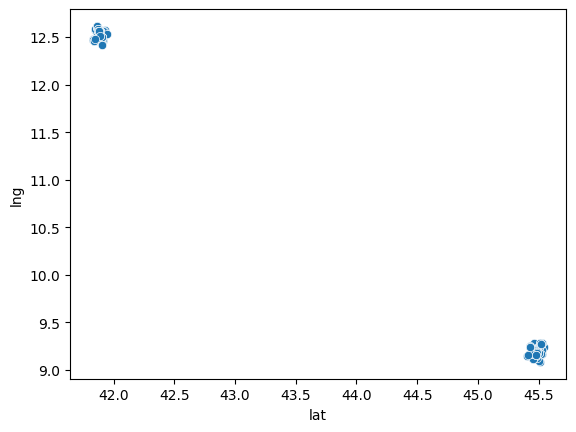

In [174]:
sns.scatterplot(data=subway_df, x="lat", y="lng")
plt.plot()

In [175]:
df_copy = add_poi(df_copy, subway_df, "subway")

In [176]:
df_copy[["subway_distance", "price"]].corr()  # very low bc venice has no subways -> restrict to milan and rome

,subway_distance,price
subway_distance,1.000000,-0.027097
price,-0.027097,1.000000


In [177]:
df = add_poi(df, subway_df, "subway")
test = add_poi(test, subway_df, "subway")

##### Train

In [178]:
poi_df["train"].value_counts()

train
yes    399
no       1
Name: count, dtype: int64

In [179]:
train_df = poi_df[["lat", "lng", "train"]]
train_df = train_df[train_df["train"].notna()]
train_df

,lat,lng,train
46,45.468701,9.181697,yes
924,45.195810,11.214229,yes
982,45.195857,11.214325,yes
983,45.195862,11.214364,yes
984,45.195896,11.214490,yes
...,...,...,...
387617,46.210341,6.142385,yes
387618,46.192598,6.153808,yes
387619,46.201420,6.166614,yes
387620,46.196591,6.197250,yes


[]

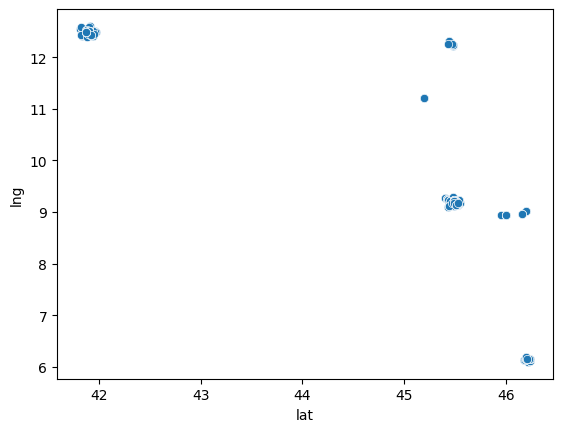

In [180]:
sns.scatterplot(data=train_df, x="lat", y="lng")
plt.plot()

In [181]:
df = add_poi(df, train_df, "train")
test = add_poi(test, train_df, "train")

##### Public Transport

In [182]:
poi_df["public_transport"].value_counts()

public_transport
platform         9227
stop_position    3092
station           401
stop                2
yes                 1
Name: count, dtype: int64

In [183]:
pt_df = poi_df[["lat", "lng", "public_transport"]]
pt_df = pt_df[pt_df["public_transport"].notna()]
pt_df.head()

,lat,lng,public_transport
42,45.469473,9.185248,stop_position
46,45.468701,9.181697,station
47,45.465532,9.186219,station
51,45.469306,9.181902,stop_position
68,45.456475,9.195268,station


In [184]:
transports = ["platform", "stop_position"]

In [185]:
for transport in transports:
    print(f"adding {transport}")
    transport_df = pt_df[pt_df["public_transport"] == transport]
    df_copy = add_poi(df_copy, transport_df, transport)

adding platform
adding stop_position


In [186]:
df_copy[["price", "platform_distance", "stop_position_distance"]].corr()

,price,platform_distance,stop_position_distance
price,1.000000,-0.066636,-0.091023
platform_distance,-0.066636,1.000000,0.955993
stop_position_distance,-0.091023,0.955993,1.000000


In [187]:
def proc_transport(data):
    for transport in transports:
        print(f"adding {transport}")
        transport_df = pt_df[pt_df["public_transport"] == transport]
        data = add_poi(data, transport_df, transport)
    return data

In [188]:
df = proc_transport(df)
test = proc_transport(test)

adding platform
adding stop_position
adding platform
adding stop_position


##### Airport

i will pick manually the main airports in milan, rome and venice

In [189]:
airport_coords = {
    "Linate": (45.461040, 9.277430),
    "Malpensa": (45.627444, 8.712276),
    "Fiumiino": (41.801978, 12.250532),
    "Ciampino": (41.799028, 12.592474),
    "Tessera": (45.501447, 12.345245),
}

In [190]:
airports_df = pd.DataFrame.from_dict(airport_coords, orient='index', columns=['lat', 'lng'])

In [191]:
airports_df

,lat,lng
Linate,45.461040,9.277430
Malpensa,45.627444,8.712276
Fiumiino,41.801978,12.250532
Ciampino,41.799028,12.592474
Tessera,45.501447,12.345245


In [192]:
df_copy = add_poi(df_copy, airports_df, "airport")

In [193]:
df_copy[["airport_distance", "price"]].corr()

,airport_distance,price
airport_distance,1.000000,0.002995
price,0.002995,1.000000


In [194]:
df = add_poi(df, airports_df, "airport")
test = add_poi(test, airports_df, "airport")

### Interaction variables

#### Average income in the region
there could be a positive relation with price!

https://en.wikipedia.org/wiki/List_of_Italian_regions_by_GDP

In [195]:
def add_income_col(data):
    
    data["avg_income"] = np.nan
    
    avg_income = {
        "Milan": 50.78, 
        "Rome": 34.62,
        "Venice": 30.208
    }
    
    for city, income in avg_income.items():
        col_name = f"city_{city}"
        data.loc[data[col_name] == 1, "avg_income"] = income
        
    assert data["avg_income"].isna().sum() == 0
    
    return data

In [196]:
df = add_income_col(df)
test = add_income_col(test)

In [197]:
df[["price", "avg_income"]].corr()

,price,avg_income
price,1.000000,0.068104
avg_income,0.068104,1.000000


#### Quality of the house
try to catch quality of the house which is better if the house has better conditions and lower age

In [198]:
df['quality'] = df['conditions'] * df['construction_year']
test['quality'] = test['conditions'] * test['construction_year']

df[["quality", "conditions", "construction_year", "price"]].corr()

,quality,conditions,construction_year,price
quality,1.000000,0.995251,0.215219,-0.010891
conditions,0.995251,1.000000,0.125960,0.000077
construction_year,0.215219,0.125960,1.000000,-0.115698
price,-0.010891,0.000077,-0.115698,1.000000


#### Floor ratio
living at the highest floors could be a pregio, and this ratio wants to catch that

In [199]:
df['floor_ratio'] = df['floor'] / df['total_floors']
test['floor_ratio'] = test['floor'] / test['total_floors']

df[["floor_ratio", "floor", "total_floors", "price"]].corr()

,floor_ratio,floor,total_floors,price
floor_ratio,1.000000,0.822735,-0.004442,0.087171
floor,0.822735,1.000000,0.005168,0.029302
total_floors,-0.004442,0.005168,1.000000,-0.001709
price,0.087171,0.029302,-0.001709,1.000000


#### Outdoor Space
houses with either a balcony or a garden will have an outdoor space

In [200]:
df["outdoor_space"] = df["garden"] + df["balcony"] != 0
test["outdoor_space"] = test["garden"] + test["balcony"] != 0

df[["outdoor_space", "garden", "balcony", "price"]].corr()

,outdoor_space,garden,balcony,price
outdoor_space,1.000000,0.384250,0.793643,-0.023921
garden,0.384250,1.000000,0.057186,-0.012738
balcony,0.793643,0.057186,1.000000,-0.002574
price,-0.023921,-0.012738,-0.002574,1.000000


#### Outdoor Space - in the centre
an outdoor space in the center is more valuable than outside !

In [201]:
df["outdoor_space_proximity"] = df["outdoor_space"] * df["distance_from_center"] 
test["outdoor_space_proximity"] = test["outdoor_space"] * test["distance_from_center"] 

df[["outdoor_space_proximity", "distance_from_center", "outdoor_space", "price"]].corr()

,outdoor_space_proximity,distance_from_center,outdoor_space,price
outdoor_space_proximity,1.000000,0.868799,0.572229,-0.140459
distance_from_center,0.868799,1.000000,0.255333,-0.170266
outdoor_space,0.572229,0.255333,1.000000,-0.023921
price,-0.140459,-0.170266,-0.023921,1.000000


#### Close Tranport
of course, livign close to a subway can increase the price of the house. Crocetta is far away :(

In [202]:
distances = [0.1, 0.3, 0.5, 1, 1.5, 2, 5]

best_corr = -np.inf
best_dist = None
for d in distances:
    df["close_transport"] = (df["train_distance"] < d) | (df["platform_distance"] < d)
    corr = df[["price", "close_transport"]].corr()["price"].close_transport
    if corr > best_corr:
        best_corr = corr
        best_dist = d
        
df["close_transport"] = (df["train_distance"] < best_dist) | (df["platform_distance"] < best_dist)
test["close_transport"] = (test["train_distance"] < best_dist) | (test["platform_distance"] < best_dist)

df[["price", "close_transport"]].corr()

,price,close_transport
price,1.000000,0.080499
close_transport,0.080499,1.000000


#### No elevator for high floor
I hate brining water bottle to the first floor without elevator, so I guess that houses at high floors with no elevator are woth less! this feature will be zero if we have elevator and increase with floor if no elevator

In [ ]:
df["missing_needed_elevator"] = (df["floor"] > 5) * ( 1 - df["elevator"] == 0 )
test["missing_needed_elevator"] = (test["floor"] > 5) * ( 1 - df["elevator"] == 0 )

df[["price", "missing_needed_elevator"]].corr()

#### Noisy
living close to airport or station can be noisy -> bad

In [204]:
df["noisy"] = (df["airport_distance"] < 10) | (df["train_distance"] < 5)
test["noisy"] = (test["airport_distance"] < 10) | (test["train_distance"] < 5)

df[["price", "noisy"]].corr()

,price,noisy
price,1.000000,0.038163
noisy,0.038163,1.000000


#### Comfortable
having a bar or a restaurant close to home can be good, especially if you hate cooking

In [205]:
df["comfortable"] = (df["university_distance"] < 1) & (df["bar_distance"] < 1) & (df["restaurant_distance"] < 1)
test["comfortable"] = (test["university_distance"] < 1) & (test["bar_distance"] < 1) & (test["restaurant_distance"] < 1)

df[["price", "comfortable"]].corr()

,price,comfortable
price,1.000000,0.110159
comfortable,0.110159,1.000000


#### Wrong floor

In [206]:
df["wrong_floor"] = df["total_floors"] < df["floor"]
test["wrong_floor"] = test["total_floors"] < test["floor"]

df[["wrong_floor", "price"]].corr()

,wrong_floor,price
wrong_floor,1.000000,0.055281
price,0.055281,1.000000


#### Zero area

In [207]:
df["zero_surface"] = (df["surface"] == 0)
test["zero_surface"] = (test["surface"] == 0)

df[["price", "zero_surface"]].corr()

,price,zero_surface
price,1.000000,0.263371
zero_surface,0.263371,1.000000


In [208]:
df_full = df.copy()

## Feature Selection

In [209]:
assert df.isna().sum().sum() == 0, "train still contains null values"
assert test.isna().sum().sum() == 0, "test still contains null values"

In [210]:
set(df.columns) - set(test.columns) 

{'price'}

This is a first manual scrematura of the features. At the end we just run pca on 15 components

### Manual Reduction

In [211]:
if "city" in df_imputed.columns:
    df_imputed = df_imputed.drop("city", axis=1)
    
df_imputed.head()  # df before feature augmentation

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price,distance_from_center,city_Milan,city_Rome,city_Venice
id,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,1,2,1980,41.901300,12.700000,175.00,30.0,2,0,1,0,3,1,1.00000,35.0,11.002100,18.000160,0,1,0
51304,900000.0,0,2,1851,41.907017,12.481311,175.00,80.0,3,0,1,1,4,3,1.00000,131.0,13.710150,1.552411,0,1,0
33032,33000.0,0,2,1960,41.976500,12.440500,204.20,30.0,4,0,1,0,4,1,1.00000,16.0,10.404263,9.911794,0,1,0
62281,166000.0,0,3,1948,45.484800,12.198200,175.00,80.0,1,1,1,0,1,2,0.99205,100.0,12.019743,11.570493,0,0,1
45681,410000.0,1,2,1928,45.424480,12.328622,65.91,80.0,3,0,2,1,4,3,1.00000,90.0,12.923912,1.711629,0,0,1


In [212]:
corr_matrix = df_imputed.corr()
corr_matrix

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,log_price,distance_from_center,city_Milan,city_Rome,city_Venice
price,1.000000,-0.002574,0.000077,-0.115698,0.045997,-0.068031,-0.000827,0.005177,0.029302,-0.012738,0.186133,0.006129,-0.001709,0.211837,0.034702,0.405092,0.609834,-0.170266,0.068312,-0.044985,-0.024754
balcony,-0.002574,1.000000,0.034530,0.231213,-0.153261,0.069873,0.003377,0.003979,0.173411,0.057186,0.143063,0.195658,0.004528,0.131617,-0.005838,0.094575,0.063531,0.208812,-0.066051,0.153479,-0.126830
conditions,0.000077,0.034530,1.000000,0.125960,0.081940,-0.111647,0.003159,0.000494,-0.063095,0.110570,0.065138,0.078146,-0.002023,-0.075541,0.003726,-0.059951,0.073558,0.031234,0.110807,-0.082338,-0.027311
construction_year,-0.115698,0.231213,0.125960,1.000000,-0.198945,-0.042842,0.004136,0.006409,0.044121,0.165296,-0.009999,0.184635,0.001372,-0.119219,-0.034931,-0.072598,-0.221494,0.380994,0.053137,0.200927,-0.342653
latitude,0.045997,-0.153261,0.081940,-0.198945,1.000000,-0.745354,-0.004347,0.008509,-0.027250,0.001336,-0.048328,-0.080902,0.005117,-0.003328,0.027829,-0.034355,0.111909,-0.442042,0.716495,-0.999583,0.463806
longitude,-0.068031,0.069873,-0.111647,-0.042842,-0.745354,1.000000,0.003464,-0.015721,-0.068792,-0.033343,0.073388,-0.174140,0.001074,0.190794,-0.052107,0.069721,-0.145577,0.377224,-0.997839,0.744081,0.242355
energy_efficiency,-0.000827,0.003377,0.003159,0.004136,-0.004347,0.003464,1.000000,-0.000176,-0.004246,0.006746,-0.003370,0.003906,0.000096,-0.004665,0.000849,-0.002992,-0.000531,-0.001125,-0.003148,0.004396,-0.002044
expenses,0.005177,0.003979,0.000494,0.006409,0.008509,-0.015721,-0.000176,1.000000,0.003078,0.005315,0.002814,0.017574,0.000015,0.000955,0.004341,0.003514,0.012257,-0.007144,0.015909,-0.008574,-0.008374
floor,0.029302,0.173411,-0.063095,0.044121,-0.027250,-0.068792,-0.004246,0.003078,1.000000,-0.075672,-0.001021,0.282648,0.005168,-0.013355,0.017984,-0.034497,0.072487,-0.104447,0.074585,0.028171,-0.132971
garden,-0.012738,0.057186,0.110570,0.165296,0.001336,-0.033343,0.006746,0.005315,-0.075672,1.000000,0.099763,-0.043757,-0.003651,0.065682,-0.015495,0.123685,0.022219,0.194185,0.032257,-0.001603,-0.038610


[]

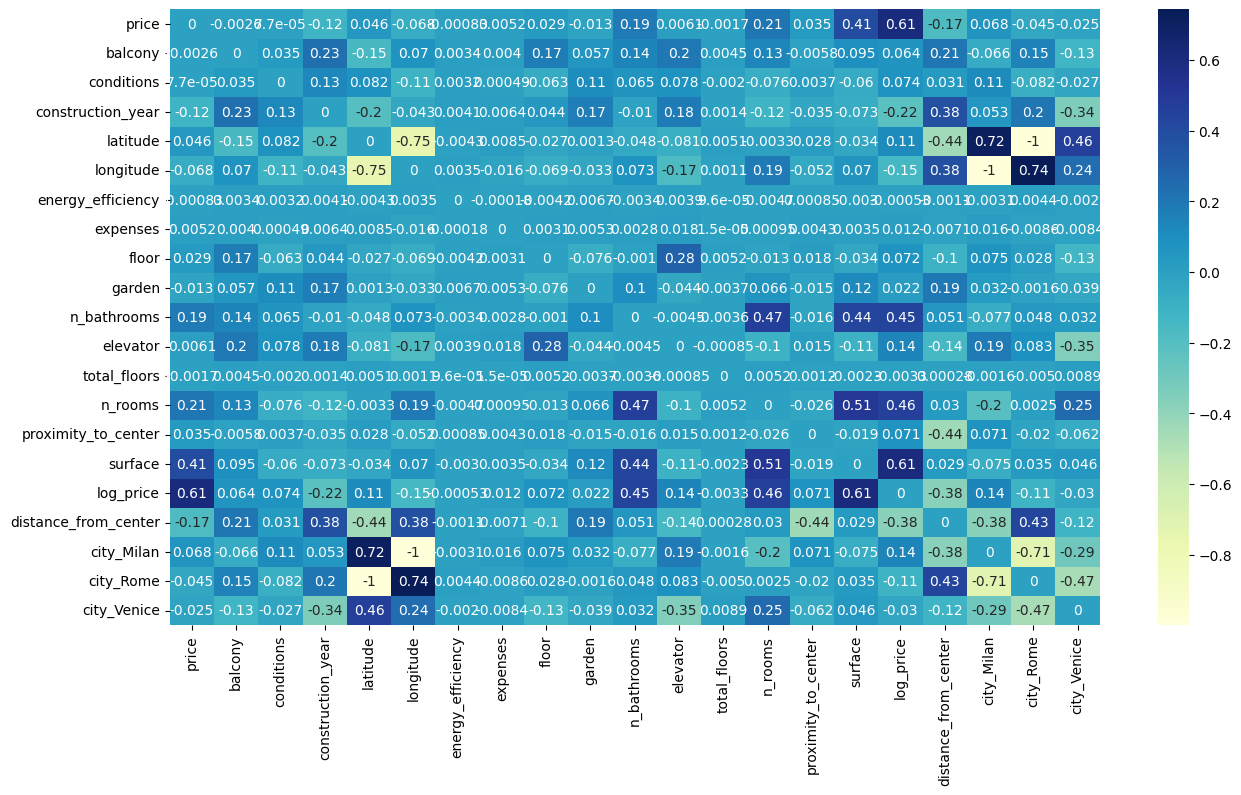

In [213]:
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix - np.eye(corr_matrix.shape[0]), annot=True, cmap="YlGnBu")
plt.plot()

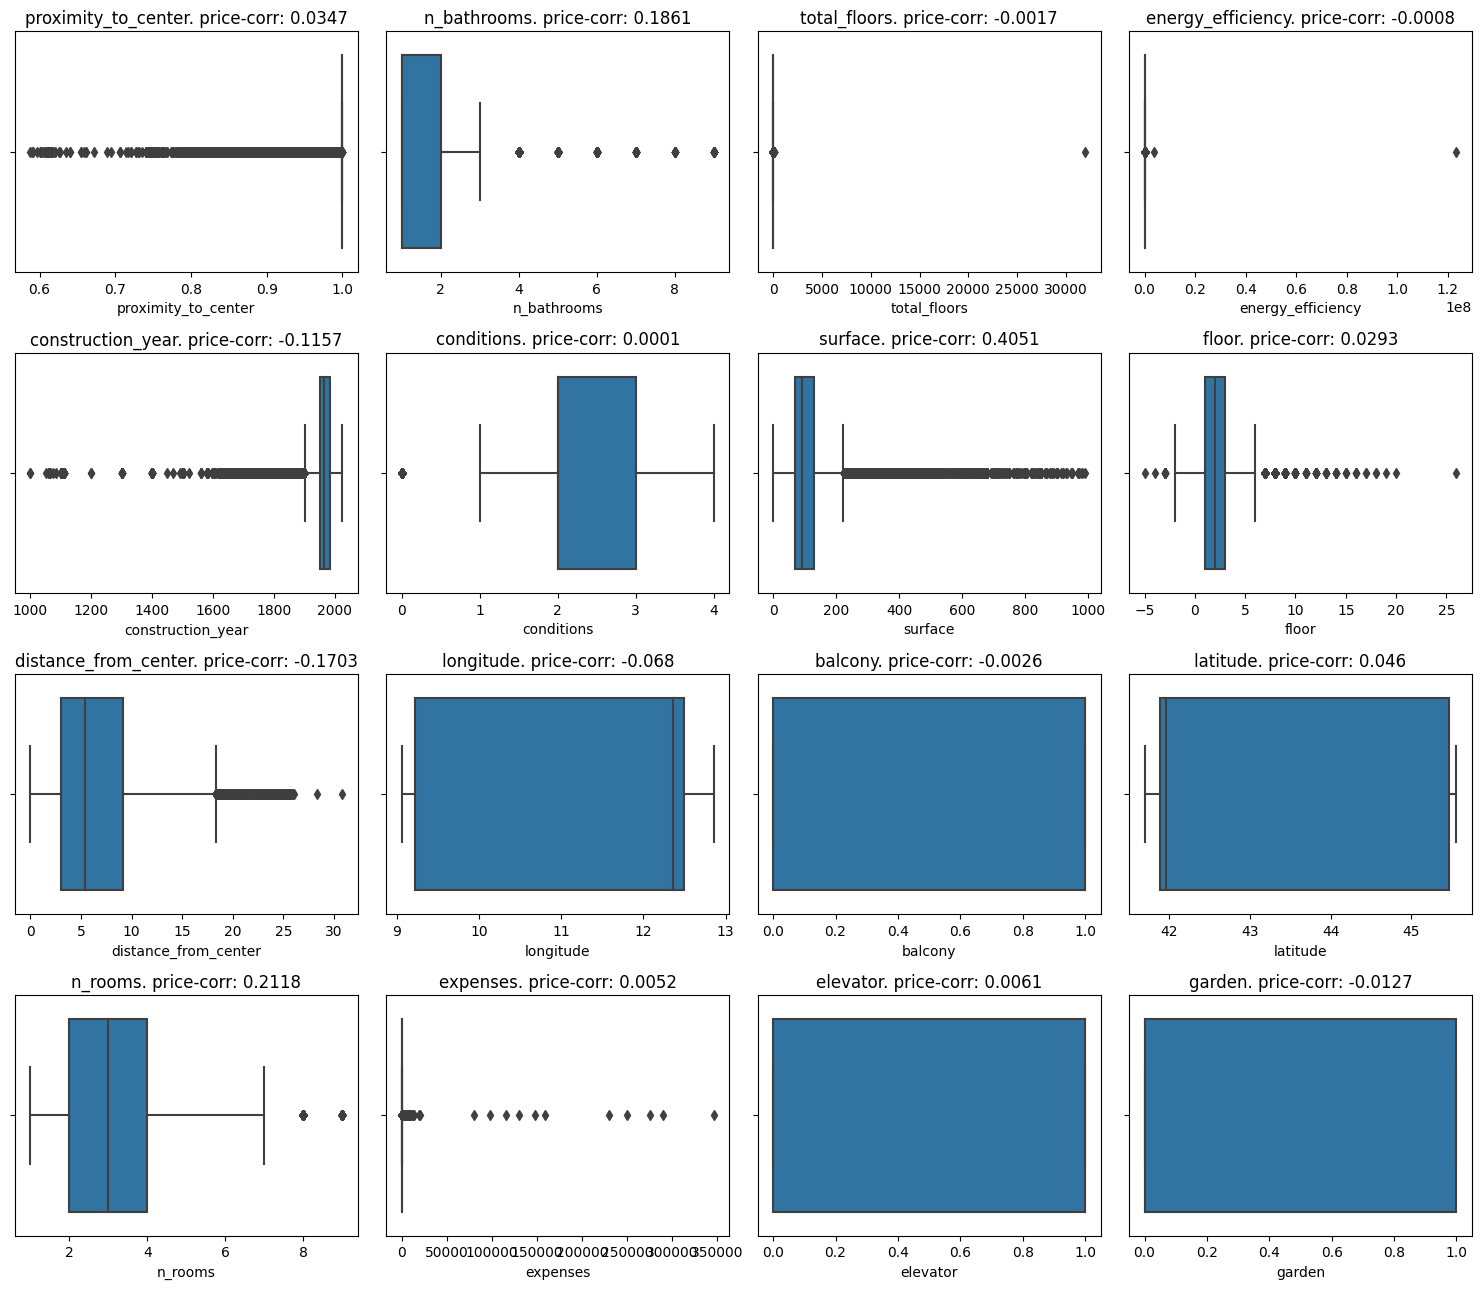

In [214]:
cols = set(df_imputed.columns) - {"price", "log_price", "city", "city_Milan", "city_Venice", "city_Rome"}

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 13))

for i, col in enumerate(cols):
    r = i // 4
    c = i % 4
    sns.boxplot(data=df, x=col, ax=axes[r][c])
    price_corr = np.around(corr_matrix[col].price, 4)
    axes[r][c].set_title(f"{col}. price-corr: {price_corr}")

plt.tight_layout()
plt.show()

In [215]:
corr_standing = np.abs(corr_matrix).sort_values(by="price", ascending=False)["price"].index
corr_matrix[corr_standing].loc["price"]

price                   1.000000
log_price               0.609834
surface                 0.405092
n_rooms                 0.211837
n_bathrooms             0.186133
distance_from_center   -0.170266
construction_year      -0.115698
city_Milan              0.068312
longitude              -0.068031
latitude                0.045997
city_Rome              -0.044985
proximity_to_center     0.034702
floor                   0.029302
city_Venice            -0.024754
garden                 -0.012738
elevator                0.006129
expenses                0.005177
balcony                -0.002574
total_floors           -0.001709
energy_efficiency      -0.000827
conditions              0.000077
Name: price, dtype: float64

In [216]:
to_drop

['balcony',
 'garden',
 'energy_efficiency',
 'total_floors',
 'expenses',
 'elevator']

In [217]:
df = df.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [218]:
df.head()  # df after feature augmentation

,price,conditions,construction_year,latitude,longitude,floor,n_bathrooms,n_rooms,proximity_to_center,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,restaurant_distance,bar_distance,hotel_distance,museum_distance,guest_house_distance,subway_distance,train_distance,platform_distance,stop_position_distance,airport_distance,avg_income,quality,floor_ratio,outdoor_space,outdoor_space_proximity,close_transport,missing_needed_elevator,noisy,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,2,1980,41.901300,12.700000,2,1,1,1.00000,35.0,18.000160,0,1,0,15.093077,10.269157,11.012326,7.889770,11.896518,7.608253,8.075003,7.543650,6.287748,8.075003,14.444563,34.620,3960,0.666667,True,18.000160,False,False,False,False,False,False
51304,900000.0,2,1851,41.907017,12.481311,3,1,3,1.00000,131.0,1.552411,0,1,0,0.956001,0.138311,0.921519,0.089368,0.414538,0.287220,0.265553,0.783028,0.036800,0.265553,15.131343,34.620,3702,0.750000,False,0.000000,True,False,True,True,False,False
33032,33000.0,2,1960,41.976500,12.440500,4,1,1,1.00000,16.0,9.911794,0,1,0,8.860499,3.878798,6.471901,4.035982,4.458415,4.542674,7.548328,3.794911,1.557312,4.441288,23.402875,34.620,3920,1.000000,False,0.000000,True,False,True,False,False,False
62281,166000.0,3,1948,45.484800,12.198200,1,1,2,0.99205,100.0,11.570493,0,0,1,4.469370,3.502686,11.725729,1.349664,3.418663,2.398742,226.983342,2.468884,1.260242,2.468884,11.610236,30.208,5844,1.000000,True,11.570493,True,False,True,False,False,False
45681,410000.0,2,1928,45.424480,12.328622,3,2,3,1.00000,90.0,1.711629,0,0,1,8.399681,1.289566,1.490445,0.129196,0.739025,0.508659,237.464142,1.938042,1.630948,1.727424,8.655994,30.208,3856,0.750000,True,1.711629,True,False,True,False,False,False


In [219]:
corr_matrix = df.corr()
corr_matrix.head()

,price,conditions,construction_year,latitude,longitude,floor,n_bathrooms,n_rooms,proximity_to_center,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,restaurant_distance,bar_distance,hotel_distance,museum_distance,guest_house_distance,subway_distance,train_distance,platform_distance,stop_position_distance,airport_distance,avg_income,quality,floor_ratio,outdoor_space,outdoor_space_proximity,close_transport,missing_needed_elevator,noisy,comfortable,wrong_floor,zero_surface
price,1.000000,0.000077,-0.115698,0.045997,-0.068031,0.029302,0.186133,0.211837,0.034702,0.405092,-0.170266,0.068312,-0.044985,-0.024754,-0.121216,-0.103685,-0.132461,-0.088991,-0.124542,-0.085798,-0.027097,-0.089921,-0.066636,-0.091023,0.002995,0.068104,-0.010891,0.087171,-0.023921,-0.140459,0.080499,0.039266,0.038163,0.110159,0.055281,0.263371
conditions,0.000077,1.000000,0.125960,0.081940,-0.111647,-0.063095,0.065138,-0.075541,0.003726,-0.059951,0.031234,0.110807,-0.082338,-0.027311,0.025490,0.022368,0.027074,0.020961,0.032313,0.028560,-0.027537,0.024274,0.014541,0.021435,-0.052578,0.107908,0.995251,-0.062777,0.070700,0.068505,-0.036972,-0.020449,-0.018616,-0.009839,-0.026698,-0.014699
construction_year,-0.115698,0.125960,1.000000,-0.198945,-0.042842,0.044121,-0.009999,-0.119219,-0.034931,-0.072598,0.380994,0.053137,0.200927,-0.342653,0.128559,0.217239,0.260342,0.205334,0.271057,0.227780,-0.343733,0.167283,0.092175,0.179450,0.136514,0.117510,0.215219,0.002895,0.263494,0.349307,-0.148609,0.014380,-0.118924,-0.171932,0.022847,0.002034
latitude,0.045997,0.081940,-0.198945,1.000000,-0.745354,-0.027250,-0.048328,-0.003328,0.027829,-0.034355,-0.442042,0.716495,-0.999583,0.463806,-0.319046,-0.365524,-0.268460,-0.374587,-0.396179,-0.357440,0.448079,-0.292429,-0.281089,-0.379184,-0.552878,0.569952,0.064205,-0.023142,-0.155176,-0.404224,0.294204,0.001932,0.178069,-0.048479,0.043001,-0.010761
longitude,-0.068031,-0.111647,-0.042842,-0.745354,1.000000,-0.068792,0.073388,0.190794,-0.052107,0.069721,0.377224,-0.997839,0.744081,0.242355,0.319127,0.324928,0.358085,0.272074,0.284392,0.234536,0.257510,0.292786,0.248982,0.334674,0.416511,-0.971010,-0.113880,-0.026252,0.062269,0.337854,-0.281445,-0.016393,-0.185101,-0.002670,-0.077911,0.009578


In [220]:
corr_standing = np.abs(corr_matrix).sort_values(by="price", ascending=False)["price"].index
corr_matrix[corr_standing].loc["price"]

price                      1.000000
surface                    0.405092
zero_surface               0.263371
n_rooms                    0.211837
n_bathrooms                0.186133
distance_from_center      -0.170266
outdoor_space_proximity   -0.140459
bar_distance              -0.132461
museum_distance           -0.124542
university_distance       -0.121216
construction_year         -0.115698
comfortable                0.110159
restaurant_distance       -0.103685
stop_position_distance    -0.091023
train_distance            -0.089921
hotel_distance            -0.088991
floor_ratio                0.087171
guest_house_distance      -0.085798
close_transport            0.080499
city_Milan                 0.068312
avg_income                 0.068104
longitude                 -0.068031
platform_distance         -0.066636
wrong_floor                0.055281
latitude                   0.045997
city_Rome                 -0.044985
missing_needed_elevator    0.039266
noisy                      0

In [221]:
irrelevant_features = list(corr_matrix["price"][np.abs(corr_matrix["price"]) < 0.05].index)
irrelevant_features = [feature for feature in irrelevant_features if "city" not in feature]  # keep cities information
irrelevant_features = [feature for feature in irrelevant_features if feature not in ["latitude", "longitude"]]  # keep lat and lng information
list(irrelevant_features)

['conditions',
 'floor',
 'proximity_to_center',
 'subway_distance',
 'airport_distance',
 'quality',
 'outdoor_space',
 'missing_needed_elevator',
 'noisy']

In [222]:
relevant_features = [feature for feature in df.columns if feature not in irrelevant_features]

In [223]:
df = df[relevant_features]
relevant_features.remove("price")
test = test[relevant_features]

[]

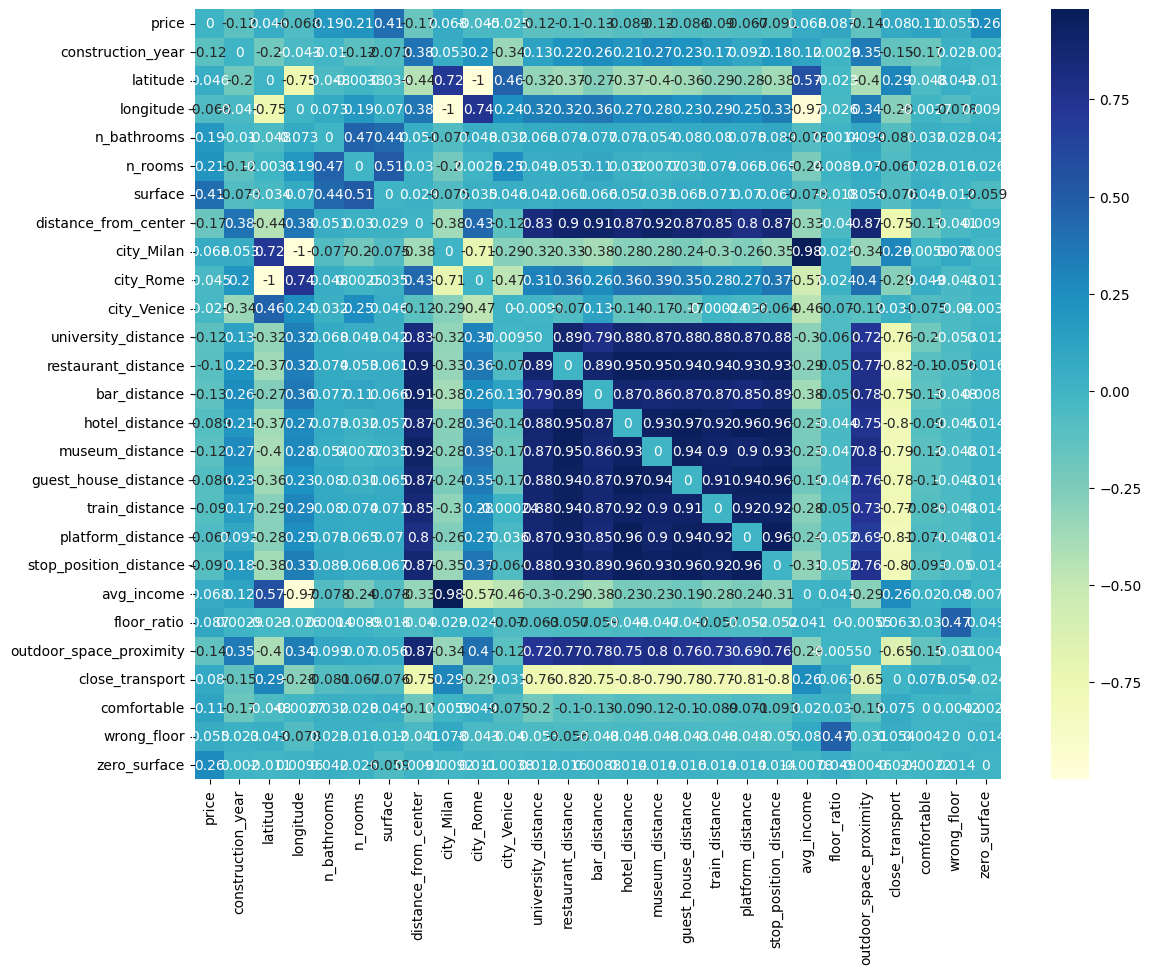

In [224]:
corr_matrix = df.corr()
corr_matrix

plt.figure(figsize=(13,10))
sns.heatmap(corr_matrix - np.eye(corr_matrix.shape[0]), annot=True, cmap="YlGnBu")

plt.plot()

In [225]:
# drop some of the distances since they all convey the same similar information 

to_drop = ["platform_distance", "stop_position_distance", "guest_house_distance", "restaurant_distance", "hotel_distance"]

df = df.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [226]:
set(df.columns) - set(test.columns)

{'price'}

### PCA reduction 

In [227]:
val_size = 0.2
train, val = train_test_split(df, test_size=val_size, random_state=51)

y_train = train["price"]
X_train = train.drop("price", axis=1)
y_val = val["price"]
X_val = val.drop("price", axis=1)

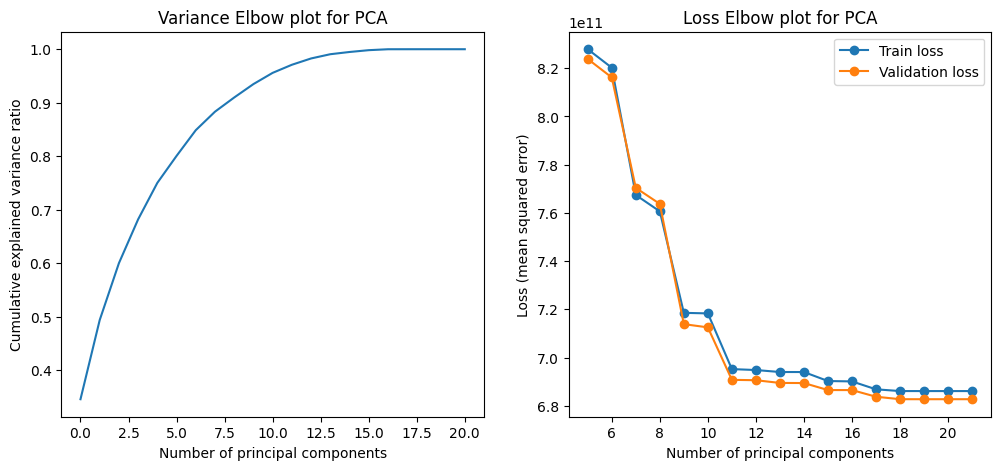

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# PCA elbow plot
pca = PCA()
pca.fit(X_train)

ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_xlabel("Number of principal components")
ax1.set_ylabel("Cumulative explained variance ratio")
ax1.set_title("Variance Elbow plot for PCA")


# Linear regression with PCA elbow plot
n_components = [i for i in range(5, df.shape[1])]  
train_losses = []
val_losses = []

for n in n_components:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    reg = LinearRegression()
    reg.fit(X_train_pca, y_train)
    train_loss = mean_squared_error(y_train, reg.predict(X_train_pca))
    val_loss = mean_squared_error(y_val, reg.predict(X_val_pca))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

ax2.plot(n_components, train_losses, '-o', label="Train loss")
ax2.plot(n_components, val_losses, '-o', label="Validation loss")
ax2.set_xlabel("Number of principal components")
ax2.set_ylabel("Loss (mean squared error)")
ax2.set_title("Loss Elbow plot for PCA")
ax2.legend()

plt.show()

In [229]:
best_pc_number = 15  # could also stop at 11 from loss but variance explained looks better at 15

pca = PCA(n_components=best_pc_number)

In [230]:
df_reduced = pca.fit_transform(df)

# Model Selection

In [ ]:
# use this to avoid pre-processing when df is modified not on purpose

# df.to_csv(cwd / "cache" / "clean_df.csv")  # save as clean_df_full if skipped feature selection 
# test.to_csv(cwd / "cache" / "clean_test.csv")  

# df = pd.read_csv(cwd / "cache" / "clean_df.csv", index_col="id")
# test = pd.read_csv(cwd / "cache" / "clean_test.csv", index_col="id")

In [231]:
seed = 51  # for replicability of scores

In [232]:
assert df.isna().sum().sum() == 0, "train still contains null values"
assert test.isna().sum().sum() == 0, "test still contains null values"
assert set(df.columns) - {"price"} - set(test.columns) == set()

In [233]:
print(df.shape)  # full train imported dataframe -> use for training and validation
df.head()

(46287, 22)


,price,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,1980,41.901300,12.700000,1,1,35.0,18.000160,0,1,0,15.093077,11.012326,11.896518,7.543650,34.620,0.666667,18.000160,False,False,False,False
51304,900000.0,1851,41.907017,12.481311,1,3,131.0,1.552411,0,1,0,0.956001,0.921519,0.414538,0.783028,34.620,0.750000,0.000000,True,True,False,False
33032,33000.0,1960,41.976500,12.440500,1,1,16.0,9.911794,0,1,0,8.860499,6.471901,4.458415,3.794911,34.620,1.000000,0.000000,True,False,False,False
62281,166000.0,1948,45.484800,12.198200,1,2,100.0,11.570493,0,0,1,4.469370,11.725729,3.418663,2.468884,30.208,1.000000,11.570493,True,False,False,False
45681,410000.0,1928,45.424480,12.328622,2,3,90.0,1.711629,0,0,1,8.399681,1.490445,0.739025,1.938042,30.208,0.750000,1.711629,True,False,False,False


In [234]:
print(test.shape)  # test df for final prediction
test.head()

(19788, 21)


,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,
18825,2010,41.917500,12.655400,1,2,72.0,14.539214,0,1,0,11.579490,6.908950,9.717413,3.874838,34.620,0.60,14.539214,False,False,False,False
30956,1900,45.446100,12.326700,1,2,60.0,0.819160,0,0,1,6.718053,1.054003,0.113699,0.664971,30.208,0.00,0.819160,True,False,False,False
47193,1912,45.456925,9.194406,3,3,140.0,1.161151,1,0,0,2.122760,0.304905,0.409683,1.642278,50.780,-0.25,0.000000,True,False,False,False
27799,1962,45.483800,12.259000,1,3,98.0,7.508076,0,0,1,0.555391,7.706443,1.662933,1.265340,30.208,1.00,7.508076,True,False,False,False
22259,2006,41.899400,12.659500,2,3,83.0,14.641964,0,1,0,11.739492,8.190904,8.955056,4.297270,34.620,1.00,14.641964,False,False,False,False


In [235]:
val_size = 0.2
train, val = train_test_split(df, test_size=val_size, random_state=seed)

y_train = train["price"]
X_train = train.drop("price", axis=1)
y_val = val["price"]
X_val = val.drop("price", axis=1)

In [236]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [237]:
pca = PCA(n_components=best_pc_number)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [238]:
model_losses = {}  # store here the losses for each model

## Linear Regression 

Although the problem does not probably meet any of the assumptions behind linear regression, I have decided to try anyway on the reduced data, so that I can have a benchmark for the other models. Both the train and the test loss seem pretty high and this suggests that this model may be too simplistic to accurately capture the relationships within the data. Indeed, even when applying Ridge regression with a regularization term of 0.01, no significant change is observed in the loss.

In [239]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

lr_train_loss = mean_squared_error(y_train, y_train_pred)
lr_val_loss = mean_squared_error(y_val, y_val_pred)

print(f"Train Loss={lr_train_loss:.2f}")
print(f"Validation Loss={lr_val_loss:.2f}")

Train Loss=686096077584.66
Validation Loss=682721224119.50


In [240]:
model_losses["Linear Regression"] = (lr_train_loss, lr_val_loss)

## Ridge Regression

both the train and the test loss seem pretty high, so I believe i'm underfitting. However, the coefficient look pretty big, so I will still try a ridge to see how the model performance changes

In [241]:
# Find best regularization term for ridge

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

rr = Ridge()

grid_search = GridSearchCV(
    estimator=rr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train_pca, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'alpha': 0.001}


In [242]:
best_params = {'alpha': 0.001}

In [243]:
# Ridge Regression with best params

rr = Ridge(**best_params)
rr.fit(X_train_pca, y_train)

y_train_pred = rr.predict(X_train_pca)
y_val_pred = rr.predict(X_val_pca)

rr_train_loss = mean_squared_error(y_train, y_train_pred)
rr_val_loss = mean_squared_error(y_val, y_val_pred)

print(f"Train Loss={rr_train_loss:.2f}")
print(f"Validation Loss={rr_val_loss:.2f}")

Train Loss=690257828193.07
Validation Loss=686511546748.51


In [244]:
model_losses["Ridge Regression"] = (rr_train_loss, rr_val_loss)

nothing has really changed. I think i should look for some more complex model which can catch some more hidden relations

## KNN regression

I ran KNN regression using varying numbers of neighbors from 1 to 50. The validation loss starts out high, but quickly decreased before slowly starting to increase again. Meanwhile, the training loss started off low and consistently increased. This behavior is expected since using fewer neighbors can result in overfitting, while using too many can result in a biased model. After analyzing the results, it was determined that the optimal choice for the number of neighbors is between 25 and 30. 

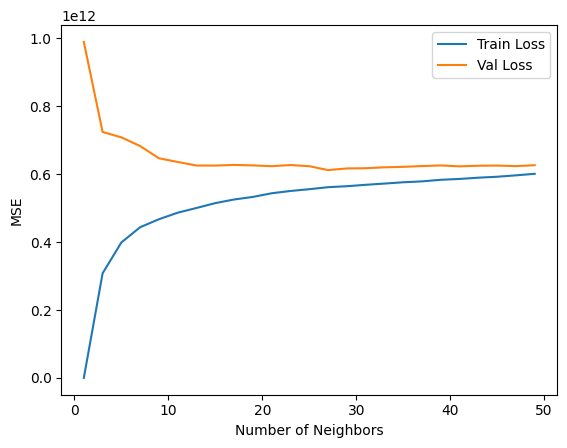

In [245]:
# Find best number of K neighbors

n_neighbors_list = [k for k in range(1, 51, 2)]

train_losses = []
val_losses = []

for n_neighbors in n_neighbors_list:
    
    knnr = KNeighborsRegressor(n_neighbors=n_neighbors)
    knnr.fit(X_train, y_train)
    
    y_train_pred = knnr.predict(X_train)
    y_val_pred = knnr.predict(X_val)
    
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
plt.plot(n_neighbors_list, train_losses, label='Train Loss')
plt.plot(n_neighbors_list, val_losses, label='Val Loss')
plt.xlabel('Number of Neighbors')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [246]:
best_k = 30  # want to pick lowest neighbors s.t. we do not overfit

In [247]:
# K-nn with best K

knnr = KNeighborsRegressor(n_neighbors=best_k)
knnr.fit(X_train, y_train)

y_train_pred = knnr.predict(X_train)
y_val_pred = knnr.predict(X_val)

knnr_train_loss = mean_squared_error(y_train, y_train_pred)
knnr_val_loss = mean_squared_error(y_val, y_val_pred)

print(f"Train loss={knnr_train_loss:.2f}")
print(f"Validation loss={knnr_val_loss:.2f}")

Train loss=566456542916.37
Validation loss=615529634214.46


In [248]:
model_losses["K-NN Regression"] = (knnr_train_loss, knnr_val_loss)

## Support Vector Regression

I conducted a grid search to determine the best kernel and regularization parameter C for the model. The results indicate that the optimal choice is a linear kernel with C=100. However, the model's performance on both the reduced and non reduced data is poor, most likely due to the non-linearity of the problem.

In [ ]:
# Find best params for SVR

svr = SVR()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(
    svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2
)
grid_search.fit(X_train_pca, y_train)

print("Best parameters:", grid_search.best_params_)

In [249]:
best_params = {
    "kernel": "linear",
    "C": 100,
}

In [250]:
# SVR with best parameters 

svr = SVR(**best_params)
svr.fit(X_train_pca, y_train)

y_train_pred = svr.predict(X_train_pca)
y_val_pred = svr.predict(X_val_pca)

svr_train_loss = mean_squared_error(y_train, y_train_pred)
svr_val_loss = mean_squared_error(y_val, y_val_pred)

print(f"Train Loss={svr_train_loss:.2f}")
print(f"Validation Loss={svr_val_loss:.2f}")

Train Loss=789324860877.30
Validation Loss=787559451408.04


In [251]:
model_losses["SV Regression"] = (svr_train_loss, svr_val_loss)

## Random Forest 

I performed a grid search to determine the optimal structure of the ensemble trees, which included the maximum depth and minimum number of samples required to split an internal node and at a leaf node. The best parameters were found to be None, 2 and 3. Subsequently, I plotted the loss as a function of the number of estimators in the forest and chose the number of estimators to be 200. It seems a good balance between efficiency costs and performance was 300, with a very low train loss and relatively low validation loss.

In [ ]:
# Find best params for RF

rfr = RandomForestRegressor()

param_grid = {
    "max_depth": [10, 20, None],  # 20
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 3]
}

grid_search = GridSearchCV(
    rfr, param_grid=param_grid, cv=3, scoring="neg_mean_squared_error", verbose=2
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

In [252]:
rf_best_params = {
    'max_depth': None, 
    'min_samples_split': 2,
    'min_samples_leaf': 5, 
}

In [ ]:
# Choose number of ensamblers

n_estimators_list = [n for n in range(50, 351, 50)]

train_losses = []
val_losses = []

for n_estimators in n_estimators_list:
    print(n_estimators)
    
    rfr = RandomForestRegressor(n_estimators=n_estimators)
    rfr.fit(X_train, y_train)
    
    y_train_pred = rfr.predict(X_train)
    y_val_pred = rfr.predict(X_val)

    train_err = mean_squared_error(y_train, y_train_pred)
    val_err = mean_squared_error(y_val, y_val_pred)
    
    train_losses.append(train_err)
    val_losses.append(val_err)

In [253]:
# the model has high volatily but we can tell that increasing the number of ensabler should not hurt generalization performances
rf_best_params["n_estimators"] = 250

In [254]:
# RF with best params

rfr = RandomForestRegressor(**rf_best_params, random_state=seed)
rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
y_val_pred = rfr.predict(X_val)

rfr_train_loss = mean_squared_error(y_train, y_train_pred)
rfr_val_loss = mean_squared_error(y_val, y_val_pred)

print(f"train MSE: {rfr_train_loss:.2f}")
print(f"validation MSE: {rfr_val_loss:.2f}")

train MSE: 286693897958.29
validation MSE: 585689615937.65


In [255]:
model_losses["Random Forest Regression"] = (rfr_train_loss, rfr_val_loss)

In [256]:
model_losses_df = pd.DataFrame(model_losses).T.reset_index()
model_losses_df.columns = ["Models", "Train Loss (millions)", "Validation Loss (millions)"]

model_losses_df.to_csv(cwd / "processed" / "losses.csv", index=False)
model_losses_df = pd.read_csv(cwd / "processed" / "losses.csv")
model_losses_df

,Models,Train Loss (millions),Validation Loss (millions)
0,Linear Regression,6.860961e+11,6.827212e+11
1,Ridge Regression,6.902578e+11,6.865115e+11
2,K-NN Regression,5.664565e+11,6.155296e+11
3,SV Regression,7.893249e+11,7.875595e+11
4,Random Forest Regression,2.866939e+11,5.856896e+11


this is the model with the best performace, so I propose to extend the model and try some different approaches to be integrated

### Extension to separated cities

In [257]:
# Store losses and predictions from different RF models
rf_losses = {}
rf_losses["nation"] = (rfr_train_loss, rfr_val_loss)

rf_predictions = {}
rf_predictions["nation"] = (y_train_pred, y_val_pred)

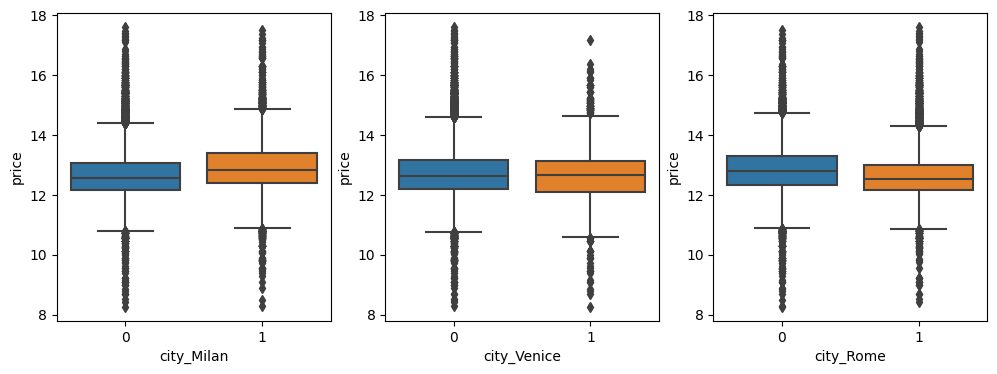

In [258]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

sns.boxplot(data=df, x="city_Milan", y=np.log(df_copy["price"]), ax=axs[0])
sns.boxplot(data=df, x="city_Venice", y=np.log(df_copy["price"]), ax=axs[1])
sns.boxplot(data=df, x="city_Rome", y=np.log(df_copy["price"]), ax=axs[2])

plt.show()

In [259]:
# Get dataframes divided by city 
mi_df = df[df["city_Milan"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ro_df = df[df["city_Rome"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ve_df = df[df["city_Venice"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)

dfs = {"Milan": mi_df, "Rome": ro_df, "Venice": ve_df}

In [260]:
val_size = 0.2

reg = RandomForestRegressor(**rf_best_params)
losses = {}

y_train_pred_city = pd.DataFrame()
y_train_true = pd.DataFrame()
y_val_pred_city = pd.DataFrame()
y_val_true = pd.DataFrame()


for city, city_df in dfs.items():
    
    city_train, city_val = train_test_split(city_df, test_size=val_size, random_state=seed)
    
    y_train = city_train["price"]
    X_train = city_train.drop("price", axis=1)
    y_val = city_val["price"]
    X_val = city_val.drop("price", axis=1)
    
    to_drop = [col for col in X_train if "city" in col]
    X_train = X_train.drop(to_drop, axis=1)
    X_val = X_val.drop(to_drop, axis=1)
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    
    reg.fit(X_train, y_train)
    
    train_pred = reg.predict(X_train)
    val_pred = reg.predict(X_val)
    
    # compute loss per city
    train_err = mean_squared_error(y_train, train_pred)
    val_err = mean_squared_error(y_val, val_pred)
    losses[city] = (train_err, val_err)
    
    # store data to compute overall loss
    y_train_pred_city = pd.concat([y_train_pred_city, pd.DataFrame(train_pred)])
    y_train_true = pd.concat([y_train_true, pd.DataFrame(y_train)])
    y_val_pred_city = pd.concat([y_val_pred_city, pd.DataFrame(val_pred)])
    y_val_true = pd.concat([y_val_true, pd.DataFrame(y_val)])

rfr_city_train_loss = mean_squared_error(y_train_pred_city.values, y_train_true.values) 
rfr_city_val_loss = mean_squared_error(y_val_pred_city.values, y_val_true.values)
print(f"Test loss {rfr_city_train_loss}")
print(f"Test loss {rfr_city_val_loss}")
print(f"Losses per separate cities: {losses}")

Test loss 330524341430.3162
Test loss 473997610571.8569
Losses per separate cities: {'Milan': (386288172297.01917, 568843577448.4404), 'Rome': (340986773573.99097, 510663318053.42377), 'Venice': (186432496488.18298, 164021860733.72992)}


In [261]:
rf_losses["city"] = (rfr_city_train_loss, rfr_city_val_loss)
rf_predictions["city"] = (y_train_pred_city, y_val_pred_city)

### Extension to separated neighborhoods 
We have exploited the geographic information of belonging to a city. However, there might be areas of a city which are much more valuable then some others. In this section, I will use k-means to create some clusters within the cities, trying to catch neighborhouuds information.

In [262]:
# Get dataframes divided by city 
mi_df = df[df["city_Milan"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ro_df = df[df["city_Rome"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ve_df = df[df["city_Venice"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)

In [263]:
city_dfs = {"Milan": mi_df, "Rome": ro_df, "Venice": ve_df}

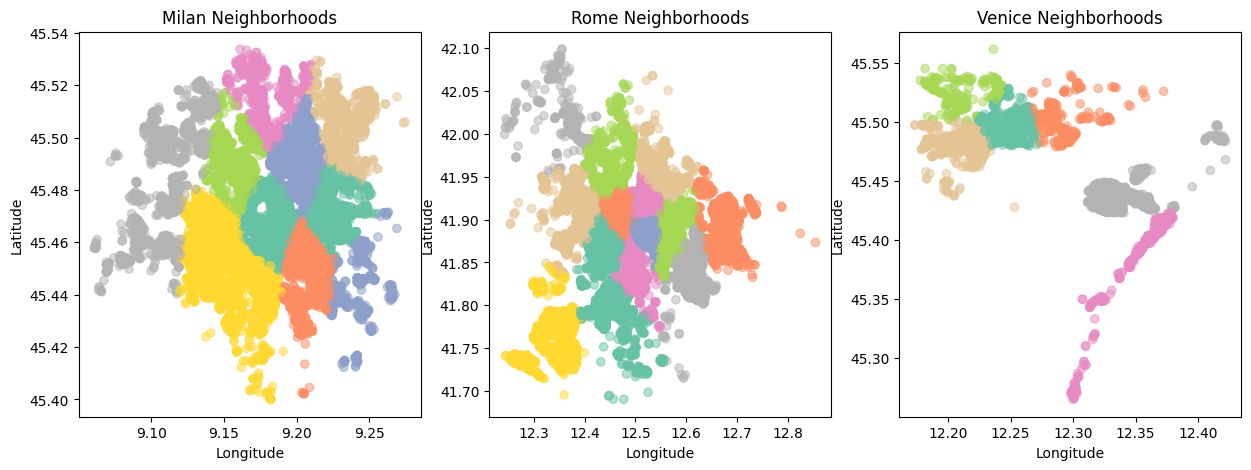

In [264]:
def create_neighborhoods(city_dfs: dict, plot=True):
    
    city_centers = {
        "Milan": (45.464081, 9.191019),  # Duomo
        "Rome": (41.890941, 12.490587),  # Colosseo
        "Venice": (45.433997, 12.338182)  # Piazza San Marco
    }
    
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    n_clusters_dict = {"Milan": 12, "Rome": 14, "Venice": 6}  # arbitrarily chosen, looks the most reasonable
    
    for i, (city, city_df) in enumerate(city_dfs.items()):

        n_clusters = n_clusters_dict[city]
        coords = city_df[["latitude", "longitude"]].values

        # Compute the distance between each point and the city center
        distances = np.sqrt(np.sum((coords - city_centers[city])**2, axis=1))

        # Use the closest points to the city center as the initial centroids
        closest_points = np.argsort(distances)[:n_clusters]
        initial_centroids = coords[closest_points]

        # Cluster the coordinates using KMeans with the initial centroids
        kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, random_state=6)
        cluster_labels = kmeans.fit_predict(coords)
        
        if plot:
            axs[i].scatter(coords[:, 1], coords[:, 0], c=cluster_labels, cmap='Set2', alpha=0.5)
            axs[i].set_xlabel("Longitude")
            axs[i].set_ylabel("Latitude")
            axs[i].set_title(f"{city} Neighborhoods")
            
        # add to the city df a categorical column representing the neighborhood
        city_df["neighborhood"] = cluster_labels
    
    return city_dfs

city_dfs = create_neighborhoods(city_dfs)

In [265]:
# One hot encode the neighboor category
encoder = OneHotEncoder(sparse_output=False)

def encode_nbrs(data):
    encoded_data = encoder.fit_transform(data[["neighborhood"]]).astype(int)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["neighborhood"]), index=data.index)
    data = pd.merge(data, encoded_df, how="inner", left_index=True, right_index=True)
    data = data.drop("neighborhood", axis=1)
    return data

city_dfs = {city: encode_nbrs(city_df) for city, city_df in city_dfs.items()}

In [266]:
city_dfs["Milan"].head()  # we have one hot encoded the neighborhoods correctly

,price,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,neighborhood_9,neighborhood_10,neighborhood_11
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20147,890000.0,1975,45.455328,9.178874,2,3,140.0,1.551992,1.225234,0.391080,0.183114,0.796754,50.78,-0.250000,0.000000,True,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0
21752,430000.0,1930,45.448800,9.173400,2,3,70.0,2.393116,1.718194,0.130415,0.882613,0.509257,50.78,0.000000,0.000000,True,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0
44538,790000.0,1980,45.436900,9.178100,3,5,190.0,3.462590,3.089191,1.453732,1.939772,1.077455,50.78,0.833333,3.462590,True,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0
57957,430000.0,1900,45.491400,9.205700,1,3,80.0,2.986642,4.178031,0.270849,0.405946,0.380670,50.78,1.000000,2.986642,True,False,False,False,0,0,0,1,0,0,0,0,0,0,0,0
46831,1950000.0,1890,45.464800,9.175000,2,5,215.0,1.192851,0.469534,0.169862,0.152163,0.415411,50.78,0.200000,1.192851,True,True,False,False,0,1,0,0,0,0,0,0,0,0,0,0


In [267]:
# This is the a very similar code that was used for separate cities, but dfs now contain Neighborhood information
val_size = 0.2
seed=51

reg = RandomForestRegressor(**rf_best_params)
losses = {}

y_train_pred_nbr = pd.DataFrame()
y_train_true = pd.DataFrame()
y_val_pred_nbr = pd.DataFrame()
y_val_true = pd.DataFrame()


for city, city_df in city_dfs.items():  # now using dict with nbrs dataframes
    
    # Get the number of neighborhoods in the city
    n_neighborhoods = len([col for col in city_df if "neighborhood" in col])
    losses[city] = {}
    
    # Obtain the single neighborhood dataframes
    for n_neighborhood in range(n_neighborhoods):
        
        col_name = "neighborhood_" + str(n_neighborhood)
        nbr_df = city_df[city_df[col_name] == 1]
        print(city, n_neighborhood)
        
        nbr_train, nbr_val = train_test_split(nbr_df, test_size=val_size, random_state=seed)

        y_train = nbr_train["price"]
        X_train = nbr_train.drop("price", axis=1)
        y_val = nbr_val["price"]
        X_val = nbr_val.drop("price", axis=1)

        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)

        reg.fit(X_train, y_train)

        train_pred = reg.predict(X_train)
        val_pred = reg.predict(X_val)

        # compute loss per city
        train_err = mean_squared_error(y_train, train_pred)
        val_err = mean_squared_error(y_val, val_pred)
        losses[city][n_neighborhood] = (train_err, val_err)

        # store data to compute overall loss
        y_train_pred_nbr = pd.concat([y_train_pred_nbr, pd.DataFrame(train_pred)])
        y_train_true = pd.concat([y_train_true, pd.DataFrame(y_train)])
        y_val_pred_nbr = pd.concat([y_val_pred_nbr, pd.DataFrame(val_pred)])
        y_val_true = pd.concat([y_val_true, pd.DataFrame(y_val)])

rfr_nbr_train_loss = mean_squared_error(y_train_pred_nbr.values, y_train_true.values) 
rfr_nbr_val_loss = mean_squared_error(y_val_pred_nbr.values, y_val_true.values)
print(f"Test loss {rfr_nbr_train_loss}")
print(f"Test loss {rfr_nbr_val_loss}")
print(f"Losses per separate neighboorhoods: {losses}")

Milan 0
Milan 1
Milan 2
Milan 3
Milan 4
Milan 5
Milan 6
Milan 7
Milan 8
Milan 9
Milan 10
Milan 11
Rome 0
Rome 1
Rome 2
Rome 3
Rome 4
Rome 5
Rome 6
Rome 7
Rome 8
Rome 9
Rome 10
Rome 11
Rome 12
Rome 13
Venice 0
Venice 1
Venice 2
Venice 3
Venice 4
Venice 5
Test loss 419197485548.20905
Test loss 623899053250.3947
Losses per separate neighboorhoods: {'Milan': {0: (113513906166.79892, 43481403344.30254), 1: (2264472212939.4175, 6700042836178.787), 2: (164761442490.12622, 5207497877691.295), 3: (879107113643.1288, 405152322343.831), 4: (33505144699.576374, 229437490725.03687), 5: (38182640246.97566, 537406283486.8172), 6: (15721767796.054598, 508061990592.81555), 7: (136689599923.2319, 61080816078.38302), 8: (224689237660.84445, 94641729057.44318), 9: (72001360546.31145, 511576982534.9897), 10: (440684863427.26117, 139554414451.08984), 11: (750952947243.5554, 58052254089.94356)}, 'Rome': {0: (38232911855.7083, 60684585446.260475), 1: (14152893025.675272, 24810533033.497623), 2: (9857130338.72

In [268]:
rf_losses["neighboorhoods"] = (rfr_nbr_train_loss, rfr_nbr_val_loss)
rf_predictions["neighboorhoods"] = (y_train_pred_nbr, y_val_pred_nbr)

this performs worse than both the model on italy and the model on cities

### Encoded Neighborhoods as only feature
Want to predict only basing on distance from the center, the city and the neighborhood. 

In [270]:
# This is the same identical code that was used for separate cities, but dfs now contain Neighborhood information
val_size = 0.2
seed=51

reg = RandomForestRegressor(**rf_best_params)
losses = {}

y_train_pred_nbr_only = pd.DataFrame()
y_train_true = pd.DataFrame()
y_val_pred_nbr_only = pd.DataFrame()
y_val_true = pd.DataFrame()


for city, city_df in city_dfs.items():  # now using dict with nbrs dataframes
    
    # only use distance and neighborhood encoding
    cols = ["price", "distance_from_center"] + [col for col in city_df if "neighborhood" in col]
    city_df = city_df[cols]
    
    nbr_only_train, nbr_only_val = train_test_split(city_df, test_size=val_size, random_state=seed)
    
    y_train = nbr_only_train["price"]
    X_train = nbr_only_train.drop("price", axis=1)
    y_val = nbr_only_val["price"]
    X_val = nbr_only_val.drop("price", axis=1)
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    
    reg.fit(X_train, y_train)
    
    train_pred = reg.predict(X_train)
    val_pred = reg.predict(X_val)
    
    # compute loss per city
    train_err = mean_squared_error(y_train, train_pred)
    val_err = mean_squared_error(y_val, val_pred)
    losses[city] = (train_err, val_err)
    
    # store data to compute overall loss
    y_train_pred_nbr_only = pd.concat([y_train_pred_nbr_only, pd.DataFrame(train_pred)])
    y_train_true = pd.concat([y_train_true, pd.DataFrame(y_train)])
    y_val_pred_nbr_only = pd.concat([y_val_pred_nbr_only, pd.DataFrame(val_pred)])
    y_val_true = pd.concat([y_val_true, pd.DataFrame(y_val)])

rfr_nbr_only_train_loss = mean_squared_error(y_train_pred_nbr_only.values, y_train_true.values) 
rfr_nbr_only_val_loss = mean_squared_error(y_val_pred_nbr_only.values, y_val_true.values)
print(f"Train loss {rfr_nbr_only_train_loss}")
print(f"Test loss {rfr_nbr_only_val_loss}")
print(f"Losses per separate neighboorhoods: {losses}")

Train loss 658148568545.0026
Test loss 986867974147.9725
Losses per separate neighboorhoods: {'Milan': (813513864692.2394, 1428363029357.7476), 'Rome': (671337739182.119, 913140116144.5422), 'Venice': (311552689484.3221, 384061957498.10736)}


In [274]:
rf_losses["neighboorhoods_only"] = (rfr_nbr_only_train_loss, rfr_nbr_only_val_loss)
rf_predictions["neighboorhoods_only"] = (y_train_pred_nbr_only, y_val_pred_nbr_only)

In [275]:
pd.DataFrame(np.hstack([y_train_pred_nbr_only.values, y_train_true.values])).corr()  
# high loss but good correlation with price. could use as regressor ? 

,0,1
0,1.000000,0.580036
1,0.580036,1.000000


In [278]:
rf_losses_df = pd.DataFrame(rf_losses).T.reset_index()
rf_losses_df.columns = ["RF extension", "Train Loss (millions)", "Validation Loss (millions)"]

# rf_losses_df.to_csv(cwd / "processed" / "rf_losses.csv", index=False)
# rf_losses_df = pd.read_csv(cwd / "processed" / "rf_losses.csv")

### Ensambling

In [279]:
rf_losses_df

,RF extension,Train Loss (millions),Validation Loss (millions)
0,nation,2.866939e+11,5.856896e+11
1,city,3.305243e+11,4.739976e+11
2,neighboorhoods,4.191975e+11,6.238991e+11
3,neighboorhoods_only,6.581486e+11,9.868680e+11


In [280]:
# just reload them as could have been modified in all processing

y_train = train["price"]
X_train = train.drop("price", axis=1)

y_val = val["price"]
X_val = val.drop("price", axis=1)

In [281]:
shortest_train_len, shortest_val_len = np.inf, np.inf

for k, v in rf_predictions.items():
    if v[0].shape[0] < shortest_train_len:
        shortest_train_len = v[0].shape[0]
    if v[1].shape[0] < shortest_val_len:
        shortest_val_len = v[1].shape[0]
        
shortest_train_len, shortest_val_len

(37015, 9258)

In [282]:
# remove some columns from the train and val sets so that they have all same lenght
rf_predictions = {
    k: (v[0][:shortest_train_len], v[1][:shortest_val_len])
    for k, v in rf_predictions.items()
}

X_train = X_train[:shortest_train_len]
y_train = y_train[:shortest_train_len]
X_val = X_val[:shortest_train_len]
y_val = y_val[:shortest_train_len]

In [283]:
X_train_ensamble = np.column_stack([df[0] for df in rf_predictions.values()])
X_val_ensamble = np.column_stack([df[1] for df in rf_predictions.values()])

#### Random Forest

In [285]:
ensemble_model = RandomForestRegressor()
ensemble_model.fit(X_train_ensamble, y_train)

ensamble_train_pred = ensemble_model.predict(X_train_ensamble)
ensamble_val_pred = ensemble_model.predict(X_val_ensamble)

ensamble_train_err = mean_squared_error(y_train, ensamble_train_pred)
ensamble_val_err = mean_squared_error(y_val, ensamble_val_pred)

print(f"Train loss {ensamble_train_err}")
print(f"Valiation loss {ensamble_val_err}")

Train loss 42891758130.85216
Valiation loss 668887017474.1633


#### Linear Regression

In [286]:
ensemble_model = LinearRegression()
ensemble_model.fit(X_train_ensamble, y_train)

ensamble_train_pred = ensemble_model.predict(X_train_ensamble)
ensamble_val_pred = ensemble_model.predict(X_val_ensamble)

ensamble_train_err = mean_squared_error(y_train, ensamble_train_pred)
ensamble_val_err = mean_squared_error(y_val, ensamble_val_pred)

print(f"Train loss {ensamble_train_err}")
print(f"Valiation loss {ensamble_val_err}")

Train loss 274333874264.7317
Valiation loss 606136788376.3735


# Prediction

In [287]:
print(df.shape)
df.head()

(46287, 22)


,price,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,1980,41.901300,12.700000,1,1,35.0,18.000160,0,1,0,15.093077,11.012326,11.896518,7.543650,34.620,0.666667,18.000160,False,False,False,False
51304,900000.0,1851,41.907017,12.481311,1,3,131.0,1.552411,0,1,0,0.956001,0.921519,0.414538,0.783028,34.620,0.750000,0.000000,True,True,False,False
33032,33000.0,1960,41.976500,12.440500,1,1,16.0,9.911794,0,1,0,8.860499,6.471901,4.458415,3.794911,34.620,1.000000,0.000000,True,False,False,False
62281,166000.0,1948,45.484800,12.198200,1,2,100.0,11.570493,0,0,1,4.469370,11.725729,3.418663,2.468884,30.208,1.000000,11.570493,True,False,False,False
45681,410000.0,1928,45.424480,12.328622,2,3,90.0,1.711629,0,0,1,8.399681,1.490445,0.739025,1.938042,30.208,0.750000,1.711629,True,False,False,False


In [288]:
print(test.shape)
test.head()

(19788, 21)


,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,
18825,2010,41.917500,12.655400,1,2,72.0,14.539214,0,1,0,11.579490,6.908950,9.717413,3.874838,34.620,0.60,14.539214,False,False,False,False
30956,1900,45.446100,12.326700,1,2,60.0,0.819160,0,0,1,6.718053,1.054003,0.113699,0.664971,30.208,0.00,0.819160,True,False,False,False
47193,1912,45.456925,9.194406,3,3,140.0,1.161151,1,0,0,2.122760,0.304905,0.409683,1.642278,50.780,-0.25,0.000000,True,False,False,False
27799,1962,45.483800,12.259000,1,3,98.0,7.508076,0,0,1,0.555391,7.706443,1.662933,1.265340,30.208,1.00,7.508076,True,False,False,False
22259,2006,41.899400,12.659500,2,3,83.0,14.641964,0,1,0,11.739492,8.190904,8.955056,4.297270,34.620,1.00,14.641964,False,False,False,False


In [289]:
reg = RandomForestRegressor(**rf_best_params)

### Cities

In [290]:
city_train_pred = pd.DataFrame(columns=["id", "price"])
city_test_pred = pd.DataFrame(columns=["id", "price"])

mi_train = df[df["city_Milan"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ro_train = df[df["city_Rome"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ve_train = df[df["city_Venice"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
trains = {"Milan": mi_train, "Rome": ro_train, "Venice": ve_train}

mi_test = test[test["city_Milan"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ro_test = test[test["city_Rome"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
ve_test = test[test["city_Venice"] == 1].drop(["city_Milan", "city_Rome", "city_Venice"], axis=1)
tests = {"Milan": mi_test, "Rome": ro_test, "Venice": ve_test}

for city, city_train in trains.items():
    
    y_train = city_train["price"]
    X_train = city_train.drop("price", axis=1)
    X_test = tests[city]
    
    to_drop = [col for col in X_train if "city" in col]
    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    reg.fit(X_train, y_train)
    
    # fill dataframe with predictions
    train_pred_df = pd.DataFrame(columns=["id", "price"])
    train_pred_df["id"] = trains[city].index
    train_pred_df["price"] = reg.predict(X_train)
    city_train_pred = pd.concat([city_train_pred, train_pred_df])
    
    pred_df = pd.DataFrame(columns=["id", "price"])
    pred_df["id"] = tests[city].index
    pred_df["price"] = reg.predict(X_test)
    city_test_pred = pd.concat([city_test_pred, pred_df])

In [291]:
print(city_train_pred.shape)
city_train_pred.head()

(46287, 2)


,id,price
0,20147,9.801770e+05
1,21752,3.843769e+05
2,44538,8.814887e+05
3,57957,4.160806e+05
4,46831,2.229276e+06


In [292]:
print(city_test_pred.shape)
city_test_pred.head()

(19788, 2)


,id,price
0,47193,1.195682e+06
1,42190,2.271509e+05
2,50303,3.862712e+05
3,34920,4.053086e+05
4,58714,4.838036e+05


In [295]:
city_test_pred.to_csv(cwd / "predictions" / "final_prediction.csv", index=False)

# Bonus - Deep Learning
It was not in my plans to try a NN for this problem but I want to do it just for fun. 

In [296]:
df.head()

,price,construction_year,latitude,longitude,n_bathrooms,n_rooms,surface,distance_from_center,city_Milan,city_Rome,city_Venice,university_distance,bar_distance,museum_distance,train_distance,avg_income,floor_ratio,outdoor_space_proximity,close_transport,comfortable,wrong_floor,zero_surface
id,,,,,,,,,,,,,,,,,,,,,,
10461,60000.0,1980,41.901300,12.700000,1,1,35.0,18.000160,0,1,0,15.093077,11.012326,11.896518,7.543650,34.620,0.666667,18.000160,False,False,False,False
51304,900000.0,1851,41.907017,12.481311,1,3,131.0,1.552411,0,1,0,0.956001,0.921519,0.414538,0.783028,34.620,0.750000,0.000000,True,True,False,False
33032,33000.0,1960,41.976500,12.440500,1,1,16.0,9.911794,0,1,0,8.860499,6.471901,4.458415,3.794911,34.620,1.000000,0.000000,True,False,False,False
62281,166000.0,1948,45.484800,12.198200,1,2,100.0,11.570493,0,0,1,4.469370,11.725729,3.418663,2.468884,30.208,1.000000,11.570493,True,False,False,False
45681,410000.0,1928,45.424480,12.328622,2,3,90.0,1.711629,0,0,1,8.399681,1.490445,0.739025,1.938042,30.208,0.750000,1.711629,True,False,False,False


In [297]:
print(train.shape, val.shape)

(37029, 22) (9258, 22)


In [298]:
y_train = np.array(train["price"])
X_train = train.drop(["price"], axis=1)

y_val = np.array(val["price"])
X_val = val.drop(["price"], axis=1)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [299]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y,  dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [300]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_lambda):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size1)
        # self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        # self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_lambda)

    def forward(self, x):
        # out = self.relu(self.bn1(self.l1(x)))
        out = self.relu(self.l1(x))
        out = self.dropout(out)
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out

In [301]:
# Train the model
def train_network(
    model,
    train_loader, 
    test_loader,
    num_epochs=30, 
    learning_rate=0.01,
    optimizer_criteria=torch.optim.Adam,
    max_grad_norm=1.0
):
    optimizer = optimizer_criteria(model.parameters(), lr=learning_rate)  
    criterion = nn.MSELoss()  # used by the challange
    
    n_total_steps_train = len(train_loader)
    n_total_steps_test = len(test_loader)

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        epoch_train_loss = np.zeros(n_total_steps_train)
        epoch_test_loss = np.zeros(n_total_steps_test)

        # Train the model
        model.train()
        for i, (features, labels) in enumerate(train_loader):
            labels = labels.view(-1, 1)
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            epoch_train_loss[i] = loss.item()

        train_losses[epoch] = np.mean(epoch_train_loss)

        # Evaluate the model on the test dataset
        model.eval()
        with torch.no_grad():
            for i, (features, labels) in enumerate(test_loader):
                labels = labels.view(-1, 1)
                # Forward pass
                outputs = model(features)
                loss = criterion(outputs, labels)

                epoch_test_loss[i] = loss.item()

            test_losses[epoch] = np.mean(epoch_test_loss)
    
        if epoch % 50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Test Loss: {test_losses[epoch]:.4f}')
            
    return train_losses, test_losses

In [302]:
def nn_parameter_tuning(
    X_train,
    y_train,
    X_val,
    y_val,
    hidden_size = 32, 
    dropout_lambda = 0.2, 
    batch_size = 1000, 
    num_epochs = 50, 
    learning_rate = 0.01, 
    optimizer_criteria = torch.optim.Adam,
):
    # create nn 
    nn = NeuralNet(X_train.shape[1], hidden_size, hidden_size, dropout_lambda)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(X_train.astype(float), y_train), 
        batch_size=batch_size, 
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(X_val.astype(float), y_val), 
        batch_size=batch_size, 
    )
    
    train_losses, test_losses = train_network(
        nn, train_loader, test_loader, num_epochs, learning_rate, optimizer_criteria
    )
    
    return train_losses, test_losses

## Hyper-parameter tuning

In [ ]:
hyperparams = {
    'hidden_size': [64, 128, 256],
    'dropout_lambda': [0, 0.2],
    'batch_size': [500, 1000],
    'num_epochs': [101],
    'learning_rate': [0.001, 0.05, 0.01],
}

losses = {}
best_val_loss = np.inf

for hidden_size in hyperparams['hidden_size']:
    for dropout_lambda in hyperparams['dropout_lambda']:
        for batch_size in hyperparams['batch_size']:
            for num_epochs in hyperparams['num_epochs']:
                for learning_rate in hyperparams['learning_rate']:
                    key = f'h{hidden_size}_dl{dropout_lambda}_bs{batch_size}_e{num_epochs}_lr{learning_rate}'
                    print(key)
                    train_loss, val_loss = nn_parameter_tuning(
                        X_train,
                        y_train,
                        X_val,
                        y_val,
                        hidden_size,
                        dropout_lambda,
                        batch_size,
                        num_epochs,
                        learning_rate
                    )
                    losses[key] = {'train_loss': train_loss, 'val_loss': val_loss}
                    if np.mean(val_loss) < best_val_loss:
                        best_val_loss = np.mean(val_loss)
                        best_params = {
                            'hidden_size': hidden_size,
                            'dropout_lambda': dropout_lambda,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'learning_rate': learning_rate
                        }


In [303]:
best_params = {
    "hidden_size": 256,
    "dropout_lambda": 0,
    "batch_size": 500,
    "learning_rate": 0.05,
}

In [304]:
net = NeuralNet(
    X_train.shape[1], 
    best_params["hidden_size"], 
    best_params["hidden_size"], 
    best_params["dropout_lambda"],
)

In [306]:
train_loader = torch.utils.data.DataLoader(
    dataset=MyDataset(X_train.astype(float), y_train), 
    batch_size=best_params["batch_size"] 
)
test_loader = torch.utils.data.DataLoader(
    dataset=MyDataset(X_val.astype(float), y_val), 
    batch_size=best_params["batch_size"] 
)

In [307]:
train_loss, val_loss = train_network(net, train_loader, test_loader, num_epochs=200, learning_rate=best_params["learning_rate"])

Epoch [0/200], Train Loss: 915196703648.4266, Test Loss: 746628498701.4736
Epoch [50/200], Train Loss: 529163281264.6400, Test Loss: 649616680852.2106
Epoch [100/200], Train Loss: 473531314838.1866, Test Loss: 645317450051.3684
Epoch [150/200], Train Loss: 389042628046.5067, Test Loss: 644871002866.5264


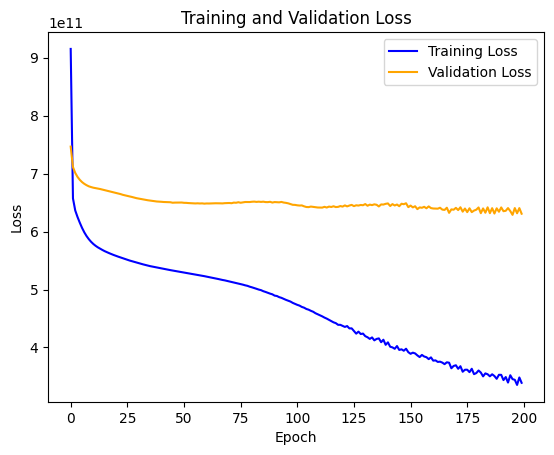

In [308]:
plt.plot(train_loss, color='blue', label='Training Loss')
plt.plot(val_loss, color='orange', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()